## Imports ##

In [1]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
# from mne import events_from_annotations, concatenate_raws

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg_raw, process_eeg_epochs
from processing.Processing_NIRS import process_nirs_raw, process_nirs_epochs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F



## Constants ##

In [2]:
BASE_PATH = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data/'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'raw/nirs/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    # 'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    # 'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',]

## Model Definitions

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim1, batch_first=True)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_dim1, hidden_size=hidden_dim2, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer leading to the output
        self.fc = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        # Pass the input through the first LSTM layer
        x, _ = self.lstm1(x)
        
        # Pass the output through the second LSTM layer
        _, (hidden, _) = self.lstm2(x)

        print(hidden.shape)
        
        # Apply dropout
        # isolate the last timestep's output for classification
        out = self.dropout(hidden[-1])
        print(out.shape)
        
        # Pass the final output to the fully connected layer and apply softmax
        logits = self.fc(out)
        print(logits.shape)
        return F.log_softmax(logits, dim=1)

## Data Formatting ##

### Feature Extraction

In [4]:
# EEG FEATURES
def extract_eeg_features(eeg_data, meta_data={}, channel_names=[]):
    """
    Extracts amplitude-related features from EEG data for each epoch and channel in a pythonic way.
    
    Parameters:
    eeg_data (numpy.ndarray): The EEG data with shape (channels, epochs, time_window).
    
    Returns:
    pandas.DataFrame: A feature matrix with shape (epochs, features), where features include
                      mean amplitude, standard deviation, and peak-to-peak amplitude for each channel.
    """
    # Extract dimensions
    num_channels, num_epochs, num_time_window = eeg_data.shape

    # channel_locations = {}
    # if 'channel_location' in meta_data:
    #     channel_location = meta_data['channel_location']
    # participant_id = {}
    # if 'participant_id' in meta_data:
    #     participant_id = meta_data['participant_id']
    
    # Prepare feature names
    features = ['mean_amplitude', 'std_amplitude', 'peak_to_peak_amplitude', 'peak_time', 'peak_amplitude']
    
    # Calculate features for each channel
    epoch_features = []
    for channel in range(num_channels):
        selected_data = eeg_data[channel]
        mean_amplitude = np.mean(selected_data, axis=1)
        std_amplitude = np.std(selected_data, axis=1)
        peak_to_peak_amplitude = np.ptp(selected_data, axis=1)
        peak_amplitude_time = np.argmax(np.abs(selected_data), axis=1)  # Time index of peak amplitude within each epoch-channel
        peak_amplitude = np.max(np.abs(selected_data), axis=1)

        # Combine features into a single 2D array where each row corresponds to an epoch-channel combination
        combined_features = np.vstack((mean_amplitude, 
                                       std_amplitude, 
                                       peak_to_peak_amplitude, 
                                       peak_amplitude_time, 
                                       peak_amplitude)).T
        
        epoch_features.append(combined_features)

    epoch_features = np.hstack(epoch_features)

    # Meta Data for contrastive loss
    participant_id = np.array([1]*num_epochs)
    # channel_location = channel_locations[channel] if channel_locations else None
    temporal_id = np.arange(num_epochs)

    # Add meta data to the feature matrix
    epoch_features = np.hstack((epoch_features, participant_id.reshape(-1, 1), temporal_id.reshape(-1, 1)))

    if channel_names == []:
        channel_names = [f'{ch+1}' for ch in range(num_channels)]
    feature_names = [f'Channel_{channel_names[ch]}_{feat}' for ch in range(num_channels) for feat in features]
    # meta data
    feature_names += ['participant_id', 'temporal_id']

    # Create DataFrame
    features_df = pd.DataFrame(epoch_features, columns=feature_names)
    
    return features_df

# NIRS FEATURES
def extract_fnirs_features(fnirs_data, hemoglobin_types=['HbO', 'HbR'], channel_names=[]):
    """
    Extracts features from fNIRS data for each epoch, channel, and hemoglobin type (HbO, HbR),
    in a pythonic way, minimizing explicit for-loops.
    
    Parameters:
    fnirs_data (numpy.ndarray): The fNIRS data with shape (channels, epochs, [HbO, HbR], timepoints).
    
    Returns:
    pandas.DataFrame: A feature matrix with each row representing an epoch and columns for
                      peak amplitude, time to peak, mean, and standard deviation for both HbO and HbR across all channels.
    """
    num_channels, num_epochs, num_hb_types, num_time_window = fnirs_data.shape
    features = ['peak_amplitude', 'time_to_peak', 'mean_concentration', 'std_deviation', 'auc']
    
    # Calculate features for each channel
    epoch_features = []
    for channel in range(num_channels):
        for hemoglobin_type in hemoglobin_types:
            # Flatten the epochs to treat each as an observation for vectorized operations
            selected_data = fnirs_data[channel, :, hemoglobin_types.index(hemoglobin_type)]
            
            # Calculate features
            peak_amplitude = np.max(selected_data, axis=1) - np.min(selected_data, axis=1)
            time_to_peak = np.argmax(selected_data, axis=1)
            mean_concentration = np.mean(selected_data, axis=1)
            std_deviation = np.std(selected_data, axis=1)
            auc = np.array([simps(y) for y in selected_data])  # Calculate AUC using Simpson's rule for each epoch-channel-Hb type combination
            
            # Combine all features into a single array
            combined_features = np.vstack((peak_amplitude, time_to_peak, mean_concentration, std_deviation, auc)).T
            epoch_features.append(combined_features)
    
    epoch_features = np.hstack(epoch_features)

    # Meta Data for contrastive loss
    participant_id = np.array([1]*num_epochs)
    # channel_location = channel_locations[channel] if channel_locations else None
    temporal_id = np.arange(num_epochs)

    # Add meta data to the feature matrix
    epoch_features = np.hstack((epoch_features, participant_id.reshape(-1, 1), temporal_id.reshape(-1, 1)))
    
    # Prepare feature names
    if channel_names == []:
        channel_names = [f'{ch+1}' for ch in range(num_channels)]
    feature_names = [f'Channel_{channel_names[ch]}_{hb}_{feat}' for ch in range(num_channels) for hb in hemoglobin_types for feat in features]    # meta data
    feature_names += ['participant_id', 'temporal_id']
    
    # Create DataFrame
    features_df = pd.DataFrame(epoch_features, columns=feature_names)
    
    return features_df

In [5]:
# Subplots EEG epoched signal and features
def plot_eeg_features(eeg_segmented, event_labels, eeg_feature_matrix, stims, legend_labels='', channel_name=''):
    # Create subplots

    # Get any channel feature names in columns
    channel_feature_names = [col for col in eeg_feature_matrix.columns if channel_name in col]
    if len(channel_feature_names) > 0:
        features_to_plot_size = len(channel_feature_names)
    else:
        features_to_plot_size = eeg_feature_matrix.shape[1]
    fig, axs = plt.subplots(2+features_to_plot_size, 1, figsize=(10, 10))

    for stim_name, counter in stims.items():
        # Get the indexes of the events
        event_indexes = np.where(event_labels == counter)[0]

        eeg_indexed = eeg_segmented[:,event_indexes]

        # Get average erp
        erp = np.mean(eeg_indexed, axis=1)

        axs[0].plot(erp.T)
        axs[0].set_title(f'EEG ERP {channel_name}')
        axs[0].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # plot events
    for stim_name, counter in stims.items():
        # Get the indexes of the events
        event_indexes = np.where(event_labels == counter)[0] 
        axs[1].scatter(event_indexes, np.ones_like(event_indexes)*counter)
        # axs[1].plot(event_indexes, np.ones_like(event_indexes)*counter, 'o')
        axs[1].set_title('Events')
        axs[1].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # plot eeg features
    if features_to_plot_size > 0:
        for i, col in enumerate(channel_feature_names):
            axs[i+2].scatter(list(range(eeg_feature_matrix.shape[0])), eeg_feature_matrix[col].T, s=3, label=event_labels)
            axs[i+2].set_title(col)
    else:
        for i in range(eeg_feature_matrix.shape[1]):
            axs[i+2].scatter(list(range(eeg_feature_matrix.shape[0])), eeg_feature_matrix.iloc[:,i].T, s=3)
            axs[i+2].set_title(eeg_feature_matrix.columns[i])

    # plot both erp
    plt.show()

# Subplots NIRS epoched signal and features
def plot_nirs_features(nirs_segmented, event_labels, nirs_feature_matrix, stims, legend_labels='', channel_name=''):
    # Create subplots

    # Get any channel feature names in columns
    channel_feature_names = [col for col in nirs_feature_matrix.columns if channel_name in col]
    if len(channel_feature_names) > 0:
        features_to_plot_size = len(channel_feature_names)
    else:
        features_to_plot_size = nirs_feature_matrix.shape[1]
    fig, axs = plt.subplots(2+features_to_plot_size, 1, figsize=(10, 10))

    for stim_name, counter in stims.items():
        # Get the indexes of the events
        event_indexes = np.where(event_labels == counter)[0]

        nirs_indexed = nirs_segmented[:,event_indexes]

        # Get average erp
        erp = np.mean(nirs_indexed, axis=1)

        axs[0].plot(erp.T)
        axs[0].set_title(f'NIRS ERP {channel_name}')
        axs[0].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # plot events
    for stim_name, counter in stims.items():
        # Get the indexes of the events
        event_indexes = np.where(event_labels == counter)[0] 
        axs[1].scatter(event_indexes, np.ones_like(event_indexes)*counter)
        axs[1].set_title('Events')
        axs[1].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # plot nirs features
    if features_to_plot_size > 0:
        for i, col in enumerate(channel_feature_names):
            axs[i+2].scatter(list(range(nirs_feature_matrix.shape[0])), nirs_feature_matrix[col].T, s=3, label=event_labels)
            axs[i+2].set_title(col)
    else:
        for i in range(nirs_feature_matrix.shape[1]):
            axs[i+2].scatter(list(range(nirs_feature_matrix.shape[0])), nirs_feature_matrix.iloc[:,i].T, s=3)
            axs[i+2].set_title(nirs_feature_matrix.columns[i])

    # plot both erp
    plt.show()

In [6]:
def get_features_event_decoding(hbo_data, 
                                hbr_data, 
                                eeg_voltage_data, 
                                offset, eeg_t_min, 
                                eeg_t_max, 
                                nirs_t_min, 
                                nirs_t_max, 
                                tasks_to_decode, 
                                groups, 
                                use_hbr=True, 
                                eeg_channel_names=[], 
                                nirs_channel_names=[],
                                eeg_meta_data={},
                                nirs_meta_data={}):
    # nirs_segmented, eeg_segmented, event_labels = get_xy_coords_signal_prediction_event_segmented(
    #                                                     hbo_data, 
    #                                                     hbr_data,
    #                                                     eeg_voltage_data,
    #                                                     offset,
    #                                                     nirs_dt,
    #                                                     eeg_t_min, 
    #                                                     eeg_t_max,
    #                                                     tasks_to_decode,
    #                                                     use_hbr=False)

    print('EEG')
    eeg_epochs = process_eeg_epochs(
                    eeg_voltage_data, 
                    eeg_t_min,
                    eeg_t_max)

    print('NIRS')
    nirs_epochs = process_nirs_epochs(
                    hbo_data, 
                    t_min=nirs_t_min,
                    t_max=nirs_t_max)


    # Find epochs not in either
    difference_eeg_nirs = np.setdiff1d(eeg_epochs.selection, nirs_epochs.selection) # in first array and not in second array
    eeg_drop_index = np.array(np.where(np.isin(eeg_epochs.selection, difference_eeg_nirs)))[0]

    difference_nirs_eeg = np.setdiff1d(nirs_epochs.selection, eeg_epochs.selection)
    nirs_drop_index = np.array(np.where(np.isin(nirs_epochs.selection, difference_nirs_eeg)))[0]

    # Drop epochs that are not in either
    eeg_epochs = eeg_epochs.drop(eeg_drop_index)
    nirs_epochs = nirs_epochs.drop(nirs_drop_index)

    eeg_epoch_events = eeg_epochs.get_annotations_per_epoch()
    nirs_epoch_events = nirs_epochs.get_annotations_per_epoch()

    event_labels_eeg = [event[0][2] for event in eeg_epoch_events]
    event_labels_nirs = [event[0][2] for event in nirs_epoch_events]

    assert len(np.setdiff1d(event_labels_eeg, event_labels_nirs)) == 0 and len(np.setdiff1d(event_labels_nirs, event_labels_eeg)) == 0

    nirs_segmented = nirs_epochs.get_data(copy=True).transpose(1,0,2)
    eeg_segmented = eeg_epochs.get_data(copy=True).transpose(1,0,2)

    # Do this for a temporay fix to add hemo dimension
    nirs_segmented = np.expand_dims(nirs_segmented, axis=2) 

    event_labels = event_labels_eeg
    _, single_events_dict = mne.events_from_annotations(eeg_voltage_data)
    event_labels = np.array([single_events_dict[event] for event in event_labels])

    # Get only tasks_to_decode
    translated_tasks = [single_events_dict[task] for task in tasks_to_decode]
    translated_tasks = np.array(np.where(np.isin(event_labels, translated_tasks)))[0]
    nirs_segmented = nirs_segmented[:,translated_tasks]
    eeg_segmented = eeg_segmented[:,translated_tasks]
    event_labels = event_labels[translated_tasks]

    # translate events in group
    counter = 0
    stims = {}
    for group_name, group in groups.items():
        group_index = [single_events_dict[task] for task in group]
        group_index = np.array(np.where(np.isin(event_labels, group_index)))[0]
        event_labels[group_index] = counter
        stims[group_name] = counter
        counter += 1

    print(f' NIRS: {nirs_segmented.shape}')
    print(f' EEG: {eeg_segmented.shape}')
    print(f' event_labels: {event_labels.shape}')

    eeg_feature_matrix = extract_eeg_features(eeg_segmented, meta_data=eeg_meta_data, channel_names=eeg_channel_names)
    print(f' EEG Features: {eeg_feature_matrix.shape}')
    nirs_feature_matrix = extract_fnirs_features(nirs_segmented, hemoglobin_types=['HbO'], channel_names=nirs_channel_names)
    print(f' NIRS Features: {nirs_feature_matrix.shape}')

    return eeg_feature_matrix, nirs_feature_matrix, event_labels, stims, eeg_segmented, nirs_segmented

## Pipeline ##

In [7]:
from sklearn.feature_selection import f_regression
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin

class MRMRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=5):
        self.k = k
        self.features = []

    def fit(self, x, y):
        """https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b#:~:text=%E2%80%9CMaximum%20Relevance%20%2D%20Minimum%20Redundancy%E2%80%9D,been%20selected%20at%20previous%20iterations
        inputs:
            x: numpy array, features
            y: numpy array, target variable
            k: number of features to select
        outputs:
            compute F-statistics and initialize correlation matrix
        """
        x = pd.DataFrame(x) # want to do because of corrwith function
        y = pd.Series(y)

        # assert we are choosing n less than matrix features
        if self.k >= x.shape[1]:
          self.features = x.columns.to_list()
          return self

        f = pd.Series(f_regression(x, y)[0], index = x.columns)
        corr = pd.DataFrame(.00001, index = x.columns, columns = x.columns)

        # initialize list of selected features and list of excluded features
        selected = []
        not_selected = x.columns.to_list()

        # repeat K times
        for i in range(self.k):

            # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
            if i > 0:
                last_selected = selected[-1]
                corr.loc[not_selected, last_selected] = x[not_selected].corrwith(x[last_selected]).abs().clip(.00001)

            # compute FCQ score for all the (currently) excluded features (this is Formula 2)
            score = f.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)

            # find best feature, add it to selected and remove it from not_selected
            best = score.index[score.argmax()]
            selected.append(best)
            not_selected.remove(best)

        self.features = selected

        return self

    def transform(self, x):
        return x[:,self.features]
    
def peak_signal_to_noise_ratio_score(estimator, x, y):
    """Compute the peak signal to noise ratio (PSNR) for a signal.
    Parameters
    ----------
    true : ndarray
        Ground-truth image.
    pred : ndarray
        Reconstructed image.
    Returns
    -------
    psnr : float
        The PSNR metric.
    """
    pred = estimator.predict(x)

    y = np.array(y, dtype=np.float64)
    pred = np.array(pred, dtype=np.float64)

    mse = np.mean((y - pred) ** 2)
    if mse == 0:
        return np.inf

    return 10 * np.log10(np.max(y) ** 2 / mse)


In [8]:
def start_pipeline( 
                X_full,
                y_full,
                params_models,
                number_of_features = 'all',
                feature_labels=[],
                n_folds_outer=6,
                n_folds_inner=6,
                n_search = 20,
                label_encoder=None,
                feature_importance=False
):
  # params_models - create one dictionary per classification algorithm containing the hyperparameters to try within the randomized search
  # n_folds_outer - number of outer folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_folds_inner - number of inner folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_search - number of combinations of scaling/feature selection/balancing/models to evaluate to find best combination

  over = SMOTE(random_state=42, sampling_strategy='auto')
  under = RandomUnderSampler(random_state=42, sampling_strategy='auto')

  # make list of named pipeline steps in the order in which they should be applied to the feature matrix
  steps = [
    ('scaler', None),
    ('over', over), 
    # ('under', under),
    ('mutal_info', SelectKBest(mutual_info_classif, k=number_of_features)),
    ('model', None),
  ]

  # create a dictionary specifying different types of scaling, feature selection, and class balancing that you want to try within the randomized search
  if number_of_features is None:
    number_of_features = np.arange(20,100, 10)

  params_preprocessing = {
                          'scaler': [StandardScaler(), MinMaxScaler()],
                          }

  # for each classification algorithm, merge the dictionary for preprocessing with the dictionary for that model
  params = [params_preprocessing | x for x in params_models] # list comprehension

  cv_outer = StratifiedKFold(n_splits=n_folds_outer, shuffle=True, random_state=0)

  for train_i, test_i in cv_outer.split(X_full, y_full):
    X_train, X_test = X_full[train_i, :], X_full[test_i, :]
    y_train, y_test = y_full[train_i], y_full[test_i]

    # print counts
    uniue_labels, counts = np.unique(y_full, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    print(f'train: {y_train.shape} test: {y_test.shape}')

    # obtain which indices will be the train data and validation data for inner folds
    cv_inner = StratifiedKFold(n_splits=n_folds_inner, shuffle=True, random_state=0)

    pipeline = Pipeline(steps)
    search = RandomizedSearchCV(pipeline,
                                params,
                                n_iter=n_search,
                                cv=cv_inner,
                                scoring='accuracy',
                                refit=True,
                                n_jobs=-1,
                                random_state=0)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    # y_pred_proba = model.predict_proba(X_test)
    
    if label_encoder is not None:
        y_test = label_encoder.inverse_transform(y_test)
        y_pred = label_encoder.inverse_transform(y_pred)

    print(classification_report(y_test, y_pred))
    print(search.best_params_)
    print(best_model)

    # best_features = best_model['MRMR'].features
    # if len(feature_labels) > 0:
    #     best_features = [feature_labels[i] for i in best_features]
    importances = []
    std= 0
    if feature_importance:
      importances = best_model['model'].feature_importances_
      std = np.std([tree.feature_importances_ for tree in best_model['model'].estimators_], axis=0)

    scores = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {scores}')

    best_features_fold = best_model['mutal_info'].get_support()
    best_features_fold = np.array(best_features_fold)

    best_features_translated = []
    for ind in range(best_features_fold.shape[0]):
        if np.any(best_features_fold[ind]):
            best_features_translated.append(feature_labels[ind])
            if feature_importance:
              print(feature_labels[ind])

    return best_model, importances, std, best_features_translated

## Parameters - Raw ##

In [9]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,2) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 200

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

## Processing

After reading in the data for each subject, we have to perform a match in the stimulous indexes for each task. This is a limitation in the dataset itself as only session start indexes are labeled in the NIRS data while individual task types are labeled in the EEG data.

After we perform this match we perform signal preprocessing to each NIRS and EEG dataset individually.

### NIRS
NIRS is bandpass filtered between 0 and 5 hz. After we ensure all source channels are within 0.1 cm from the dector to ensure proper calibration of every channel we use. We then convert the raw voltage to optical density measurment. We then apply beer-lambert law to seperate oxyginated and deoxyginated hemoglobin measurments. We then filter out NIRS related noise.
NIRS, measuring hemoglobyn, has a number of physiological interferences that must be filterd out. Cardiac activities such as heartrate has a frequency range of 0.8 to 1.5 Hz, respiratory activities have a frequency range of 0.2-0.5 Hz, and arterial blood pressure changes have a frequency of 0.1 Hz (Mayer waves with very low-frequency volatility of about 0.04 Hz) [32]. Signals related to neural activities in fNIRS are generally at a frequency range of 0.003 to 0.08 Hz. Since there is a potential overlap in neural activity related signals and noise, a discrete wavlett decomposition function was performed to filter overlap. We choose the band between, 0.003 and 0.080.

![Alt text](nirs_processing-1.png)
The above image shows the different levels of the DWF and how the signal was reconstructed to remove noise below level 6.


Lastly we epoch the data based on a designated time of -1 to 10 seconds around each evoked stimulous. This large time window is to capture the delayed response of hemoglobyn changes.

### EEG
EEG is first band pass between 0 and 80 hz. This is because the voltage measurment below 1 hz for EEG is considered unreliable. We then use the EOG channels (which are channels at the base of the ear that just measure environmental noise and eye blinks) and a independent component analysis to filter out environmental noise and eye blinks. This is done manually by comparing the recordings of the EOG channel with the components in the ICA. We then reject any channels with a abnormaly high voltage measurment.

Lastly we epoch the data the same way as NIRS except we use as the EEG voltage response to stimulous is much faster then NIRS. We also seperate out specific band windows for alpha, beta, gamma, delta, and theta. This is to later make features based around these band windows as previous studies have shown that different neural activities accure in each band.

![Alt text](eeg_waves_processing-1.png)

The Above image shows the different bands of voltage data from EEG.

### Load Raw ###

In [10]:
processed_eeg_subject_list = []
processed_eeg_epoch_subject_list = []
processed_nirs_subject_list = []

# Loop for subjects
for subject_id in subjects:
    eeg_pickle_file = os.path.join(ROOT_DIRECTORY_EEG, subject_id, f'{subject_id}_eeg_processed.pkl')
    nirs_pickle_file = os.path.join(ROOT_DIRECTORY_NIRS, subject_id, f'{subject_id}__nirs_processed.pkl')
    if (not redo_preprocessing and do_processing and 
        (os.path.exists(eeg_pickle_file))
    ):  
        # voltage
        with open(eeg_pickle_file, 'rb') as file:
            subject_eeg_voltage = pickle.load(file)

    else:
        print(f'Starting eeg processing of {subject_id}')
        raw_eeg_voltage, eeg_events_dict  = read_subject_raw_eeg(
            os.path.join(ROOT_DIRECTORY_EEG, subject_id),
            tasks,
            EEG_EVENT_TRANSLATIONS,
            TASK_STIMULOUS_TO_CROP,
            eeg_coords=EEG_COORDS)
        print(f'eeg_before: {raw_eeg_voltage.get_data().shape}')
        
        subject_eeg_voltage = raw_eeg_voltage
        if do_processing:
            subject_eeg_voltage = process_eeg_raw(
                raw_eeg_voltage, 
                l_freq=None,
                h_freq=80, 
                resample=None)
            
            print(f'eeg_after: {subject_eeg_voltage.get_data().shape}')
            
            with open(eeg_pickle_file, 'wb') as file:
                pickle.dump(subject_eeg_voltage, file, pickle.HIGHEST_PROTOCOL)

    if (not redo_preprocessing and do_processing and 
        os.path.exists(nirs_pickle_file)
    ):
        with open(nirs_pickle_file, 'rb') as file:
            subject_nirs = pickle.load(file)
    else:
        print(f'Starting nirs processing of {subject_id}')
        raw_nirs_intensity, raw_slope_dict = read_subject_raw_nirs(
            root_directory=os.path.join(ROOT_DIRECTORY_NIRS, subject_id),
            tasks_to_do=tasks,
            trial_to_check=TRIAL_TO_CHECK_NIRS[subject_id],
            nirs_event_translations=NIRS_EVENT_TRANSLATIONS,
            eeg_translation_events_dict=eeg_events_dict,
            task_stimulous_to_crop=TASK_STIMULOUS_TO_CROP)
        print(f'nirs_before: {raw_nirs_intensity.get_data().shape}')

        subject_nirs = raw_nirs_intensity
        if do_processing:
            subject_nirs = process_nirs_raw(
                raw_nirs_intensity,
                resample=None)
            print(f'nirs_after: {subject_nirs.get_data().shape}')

            with open(nirs_pickle_file, 'wb') as file:
                pickle.dump(subject_nirs, file, pickle.HIGHEST_PROTOCOL)

    processed_eeg_subject_list.append(subject_eeg_voltage)
    processed_nirs_subject_list.append(subject_nirs)

# Concatenate subjects
eeg_processed_voltage = processed_eeg_subject_list[0]
if len(processed_eeg_subject_list) > 1:
    eeg_processed_voltage = mne.concatenate_raws(processed_eeg_subject_list, preload=False).load_data()

nirs_processed_hemoglobin = processed_nirs_subject_list[0]
if len(processed_nirs_subject_list) > 1:
    # preload = False because mne was throwing a format error without, load after
    nirs_processed_hemoglobin = mne.concatenate_raws(processed_nirs_subject_list, preload=False).load_data()

# Resample
if eeg_processed_voltage.info['sfreq'] != eeg_sample_rate:
    eeg_processed_voltage.resample(eeg_sample_rate)
if nirs_processed_hemoglobin.info['sfreq'] != fnirs_sample_rate:
    nirs_processed_hemoglobin.resample(fnirs_sample_rate)

# Break out different wave bands
eeg_filtered_waves = {'full': eeg_processed_voltage.copy()}
# if eeg_sample_rate/2 > 4:
#     eeg_filtered_waves['delta'] = eeg_processed_voltage.copy().filter(l_freq=0.5, h_freq=4)
# if eeg_sample_rate/2 > 8:
#     eeg_filtered_waves['theta'] = eeg_processed_voltage.copy().filter(l_freq=4, h_freq=8)
# if eeg_sample_rate/2 > 12:
#     eeg_filtered_waves['alpha'] = eeg_processed_voltage.copy().filter(l_freq=8, h_freq=12)
# if eeg_sample_rate/2 > 30:
#     eeg_filtered_waves['beta'] = eeg_processed_voltage.copy().filter(l_freq=12, h_freq=30)
# if eeg_sample_rate/2 > 80:
#     eeg_filtered_waves['gamma'] = eeg_processed_voltage.copy().filter(l_freq=30, h_freq=80)

### Parameters - Decoding ###

In [11]:
# Time window (seconds)
eeg_t_min = -0.5
eeg_t_max = 0.9
nirs_t_min = -0.5
nirs_t_max = 10
offset = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
n_epochs = 100

# Define channels to use
# nirs_channels_to_use_base = list(NIRS_COORDS.keys())
use_hbr = False
nirs_channels_to_use_base = ['AF7','AFF5', 'AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
# eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channels_to_use = ['Cz', 'P7']#['P7']


# tasks_to_decode = ['3-back non-target', '3-back target']
# tasks_to_decode = ['0-back target', '2-back non-target', '2-back target', '3-back non-target', '3-back target', 'go', 'nogo', 'verbal_fluency', 'baseline']
# groups ={
#     'nback': ['0-back target', '2-back non-target', '2-back target', '3-back non-target', '3-back target'],
#     'gonogo': ['go', 'nogo'],
#     'wd': ['verbal_fluency', 'baseline']
# }

# tasks_to_decode = ['2-back non-target', '2-back target', '3-back non-target', '3-back target']
# groups ={
#     'target': ['2-back target', '3-back target'],
#     'non-target': ['2-back non-target', '3-back non-target' ]
# }

# tasks_to_decode = ['2-back non-target', '2-back target']
# groups ={
#     'target': ['2-back target'],
#     'non-target': ['2-back non-target']
# }

tasks_to_decode = ['2-back non-target', '2-back target', '3-back non-target', '3-back target']
groups ={
    '2-back': ['2-back target', '2-back non-target'],
    '3-back': ['3-back non-target', '3-back target']
}


### Test Raw ###

Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
{'0-back session': 10001, '0-back target': 10002, '2-back non-target': 10003, '2-back session': 10004, '2-back target': 10005, '3-back non-target': 10006, '3-back session': 10007, '3-back target': 10008, 'Stimulus/S208': 208, 'baseline': 10009, 'go': 10010, 'gonogo session': 10011, 'nogo': 10012, 'session_0': 10013, 'session_1': 10014, 'session_2': 10015, 'verbal_fluency': 10016}
events: 1011
events in raw [[  8652      0  10013]
 [  8652      0  10007]
 [  8678      0  10006]
 ...
 [945639      0  10016]
 [951501      0  10009]
 [957574      0    208]]
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1002 matching ev

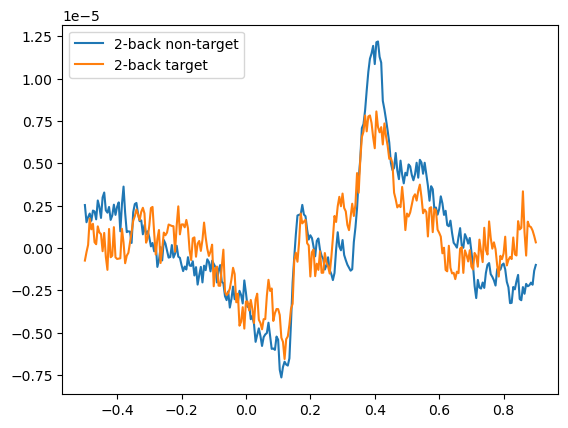

Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1002 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1002 events and 106 original time points ...
30 bad epochs dropped
['S1_D1 hbo']


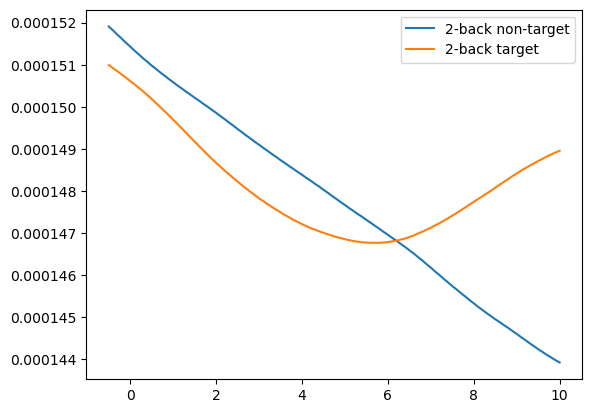

In [12]:
# Get EEG epochs
eeg_epochs = process_eeg_epochs(
                eeg_filtered_waves['full'], 
                eeg_t_min,
                eeg_t_max)

epoch_channel_select = ['Cz']
epoch_eeg_select = eeg_epochs.copy().pick(epoch_channel_select)
test_erp = epoch_eeg_select["2-back non-target"].average()
test_erp_2 = epoch_eeg_select["2-back target"].average()
# get data
data = test_erp.data
data_2 = test_erp_2.data
# plot on same plot 
plt.plot(test_erp.times, data.T)
plt.plot(test_erp_2.times, data_2.T)
# legend
plt.legend(['2-back non-target', '2-back target'])
plt.show()

# Get fNIRS epochs
nirs_epochs = process_nirs_epochs(
                nirs_processed_hemoglobin, 
                t_min = nirs_t_min,
                t_max = nirs_t_max)

epoch_channel_select = ['AF7']
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(epoch_channel_select, NIRS_COORDS, nirs_processed_hemoglobin.ch_names)

epoch_channel_select = [f'{c} hbo' for c in nirs_channels_to_use_ids]
print(epoch_channel_select)

epoch_nirs_select = nirs_epochs.copy().pick(epoch_channel_select)
test_nirs = epoch_nirs_select["2-back non-target"].average()
test_nirs_2 = epoch_nirs_select["2-back target"].average()
# get data
data = test_nirs.data
data_2 = test_nirs_2.data
# plot on same plot
plt.plot(test_nirs.times, data.T)
plt.plot(test_nirs_2.times, data_2.T)
# legend
plt.legend(['2-back non-target', '2-back target'])
plt.show()

### Extract Channels ###

In [13]:
# Predict EEG

# Get NIRS channels to use
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(nirs_channels_to_use_base, NIRS_COORDS, nirs_processed_hemoglobin.ch_names)
print(nirs_channels_to_use_ids)
print(nirs_processed_hemoglobin.ch_names)

eeg_voltage_data = eeg_filtered_waves['full'].copy().pick(picks=eeg_channels_to_use)
if do_processing:
    nirs_channels_to_use_hbo = [f'{c} hbo' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} hbr' for c in nirs_channels_to_use_ids]
else:
    nirs_channels_to_use_hbo = [f'{c} 760' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} 850' for c in nirs_channels_to_use_ids]
    
hbo_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbo)
hbr_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbr)

# For labeling
nirs_channels_to_use = nirs_channels_to_use_base
# nirs_channels_to_use = [f'{c} hbo' for c in nirs_channels_to_use_ids]+[f'{c} hbr' for c in nirs_channels_to_use_ids]
if use_hbr:
    nirs_channels_to_use = nirs_channels_to_use_hbo+nirs_channels_to_use_hbr
else:
    nirs_channels_to_use = nirs_channels_to_use_hbo

# Meta Data
eeg_meta_data = {
    'channel_location': eeg_channels_to_use,
    'participant_id': subjects
}

nirs_meta_data = {
    'channel_location': nirs_channels_to_use,
    'participant_id': subjects
}

Channel name AFp5h not found in NIRS_COORDS
['S1_D1', 'S1_D2', 'S2_D3', 'S9_D9', 'S9_D10', 'S10_D9', 'S10_D10']
['S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', 'S1_D14 hbo', 'S1_D14 hbr', 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D3 hbo', 'S2_D3 hbr', 'S3_D1 hbo', 'S3_D1 hbr', 'S3_D2 hbo', 'S3_D2 hbr', 'S3_D3 hbo', 'S3_D3 hbr', 'S3_D4 hbo', 'S3_D4 hbr', 'S4_D2 hbo', 'S4_D2 hbr', 'S4_D4 hbo', 'S4_D4 hbr', 'S4_D5 hbo', 'S4_D5 hbr', 'S5_D3 hbo', 'S5_D3 hbr', 'S5_D4 hbo', 'S5_D4 hbr', 'S5_D6 hbo', 'S5_D6 hbr', 'S6_D4 hbo', 'S6_D4 hbr', 'S6_D5 hbo', 'S6_D5 hbr', 'S6_D6 hbo', 'S6_D6 hbr', 'S6_D7 hbo', 'S6_D7 hbr', 'S7_D5 hbo', 'S7_D5 hbr', 'S7_D7 hbo', 'S7_D7 hbr', 'S7_D10 hbo', 'S7_D10 hbr', 'S8_D6 hbo', 'S8_D6 hbr', 'S8_D7 hbo', 'S8_D7 hbr', 'S9_D7 hbo', 'S9_D7 hbr', 'S9_D9 hbo', 'S9_D9 hbr', 'S9_D10 hbo', 'S9_D10 hbr', 'S10_D9 hbo', 'S10_D9 hbr', 'S10_D10 hbo', 'S10_D10 hbr', 'S10_D11 hbo', 'S10_D11 hbr', 'S10_D12 hbo', 'S10_D12 hbr', 'S11_D5 hbo', 'S11_D5 hbr', 'S11_D10 hbo', 'S11_D10 hbr', 'S1

## Event Prediction ##

In [14]:
eeg_feature_matrix, nirs_feature_matrix, event_labels, stims, eeg_segmented, nirs_segmented = get_features_event_decoding(hbo_data, 
                                                                                                                          hbr_data, 
                                                                                                                          eeg_voltage_data, 
                                                                                                                          offset, 
                                                                                                                          eeg_t_min, 
                                                                                                                          eeg_t_max, 
                                                                                                                          nirs_t_min, 
                                                                                                                          nirs_t_max, 
                                                                                                                          tasks_to_decode, 
                                                                                                                          groups,
                                                                                                                          use_hbr=use_hbr,
                                                                                                                          eeg_channel_names=eeg_channels_to_use,
                                                                                                                          nirs_channel_names=nirs_channels_to_use,
                                                                                                                          eeg_meta_data=eeg_meta_data,
                                                                                                                          nirs_meta_data=nirs_meta_data)

# legend_labels = ['Non-Target', 'Target']
legend_labels = stims.keys()

EEG
Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
{'0-back session': 10001, '0-back target': 10002, '2-back non-target': 10003, '2-back session': 10004, '2-back target': 10005, '3-back non-target': 10006, '3-back session': 10007, '3-back target': 10008, 'Stimulus/S208': 208, 'baseline': 10009, 'go': 10010, 'gonogo session': 10011, 'nogo': 10012, 'session_0': 10013, 'session_1': 10014, 'session_2': 10015, 'verbal_fluency': 10016}
events: 1011
events in raw [[  8652      0  10013]
 [  8652      0  10007]
 [  8678      0  10006]
 ...
 [945639      0  10016]
 [951501      0  10009]
 [957574      0    208]]
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1002 matchin

/var/folders/n0/57fvb7vn0s34qknk04xxkbxh0000gn/T/ipykernel_90338/4073251057.py:94: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  auc = np.array([simps(y) for y in selected_data])  # Calculate AUC using Simpson's rule for each epoch-channel-Hb type combination


### EEG Feature Analysis ###

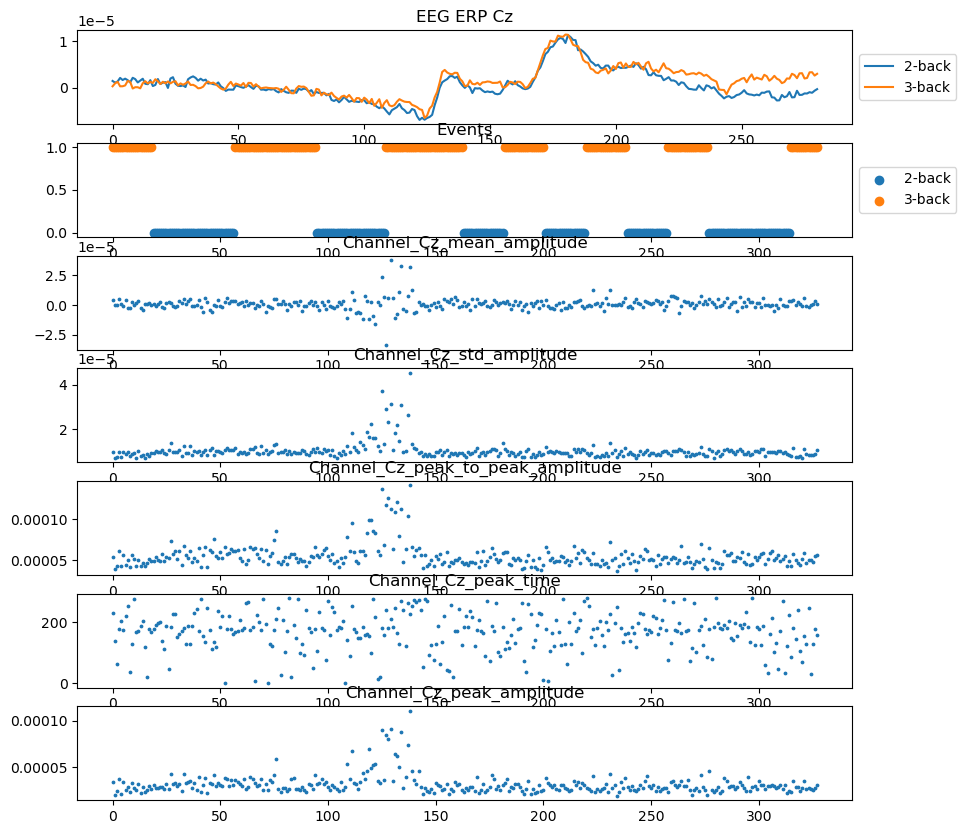

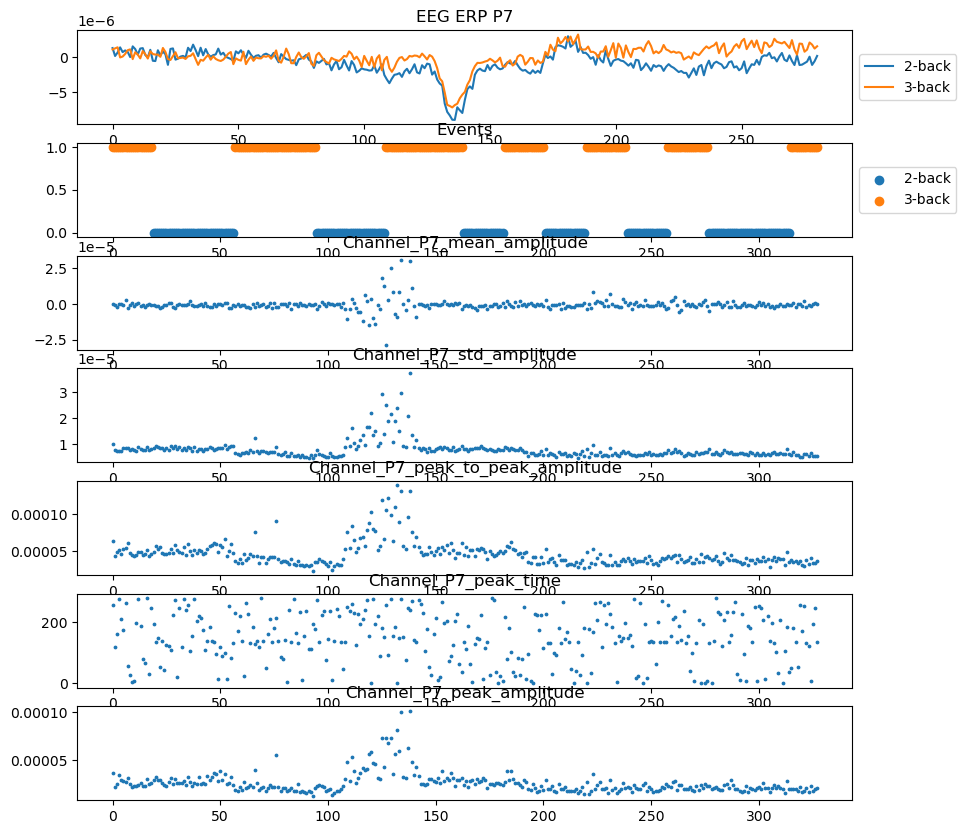

In [15]:
# EEG
for channel_index, channel_name in enumerate(eeg_channels_to_use):
    eeg_segmented_channel = eeg_segmented.copy()[channel_index]
    eeg_segmented_channel = np.expand_dims(eeg_segmented_channel, axis=0)
    plot_eeg_features(eeg_segmented_channel, 
                      event_labels, 
                      eeg_feature_matrix, 
                      stims, 
                      legend_labels=legend_labels, 
                      channel_name=channel_name)

### NIRS Feature Analyis ###

S1_D1 hbo


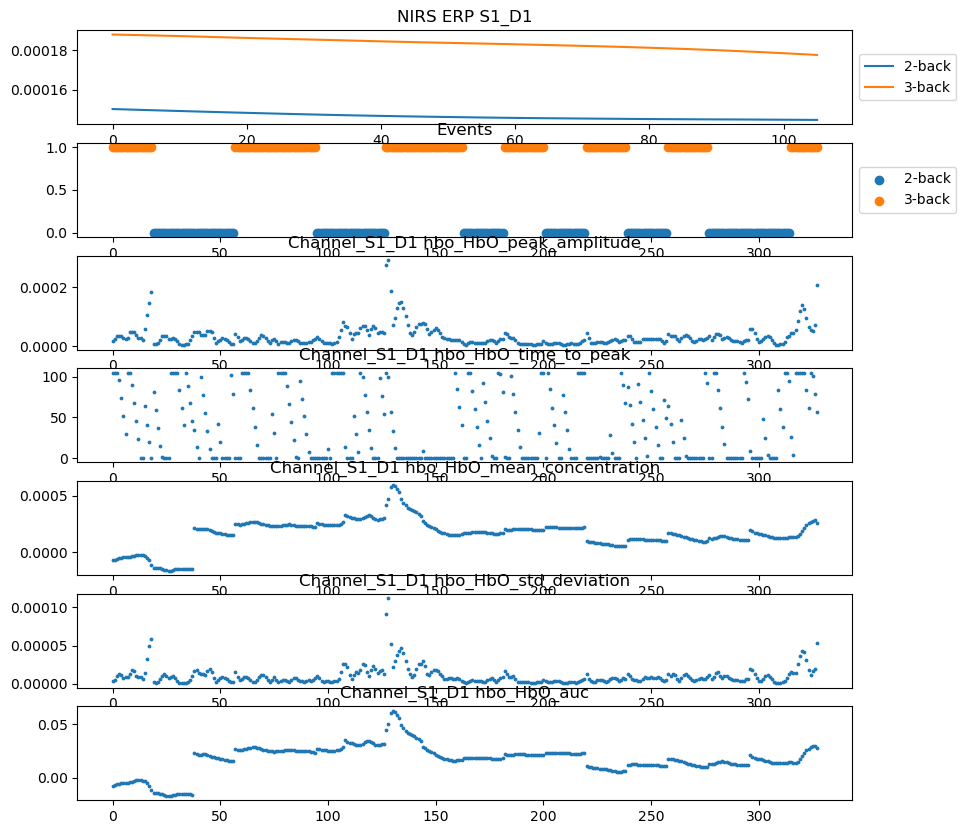

S1_D2 hbo


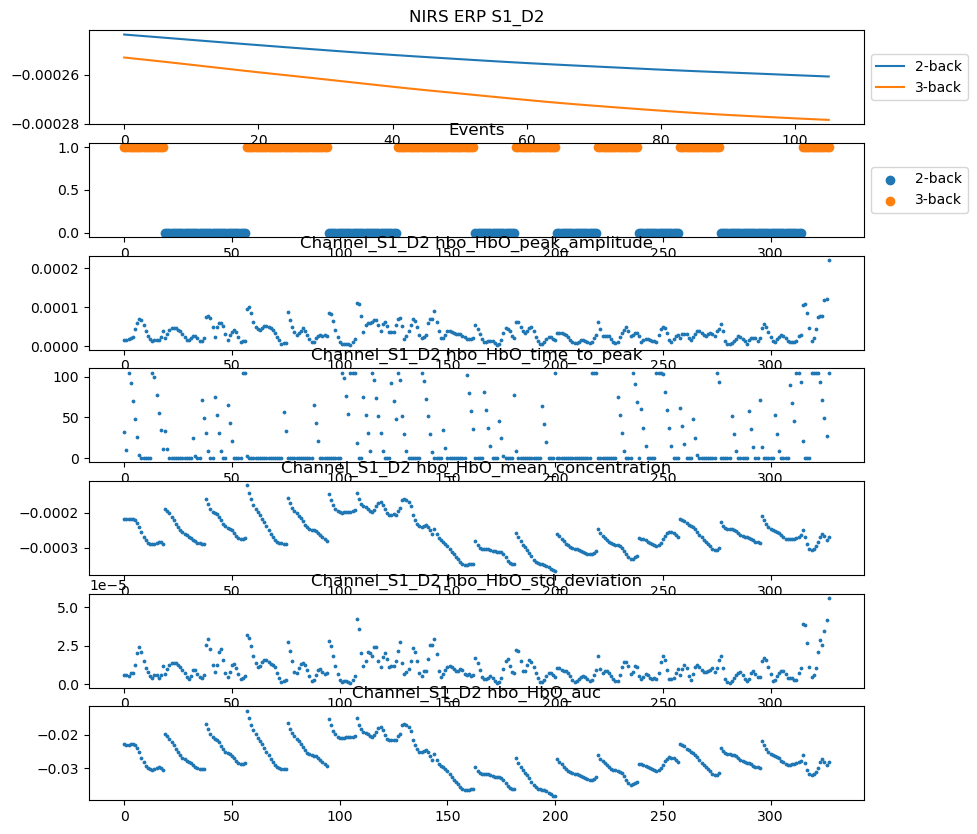

S2_D3 hbo


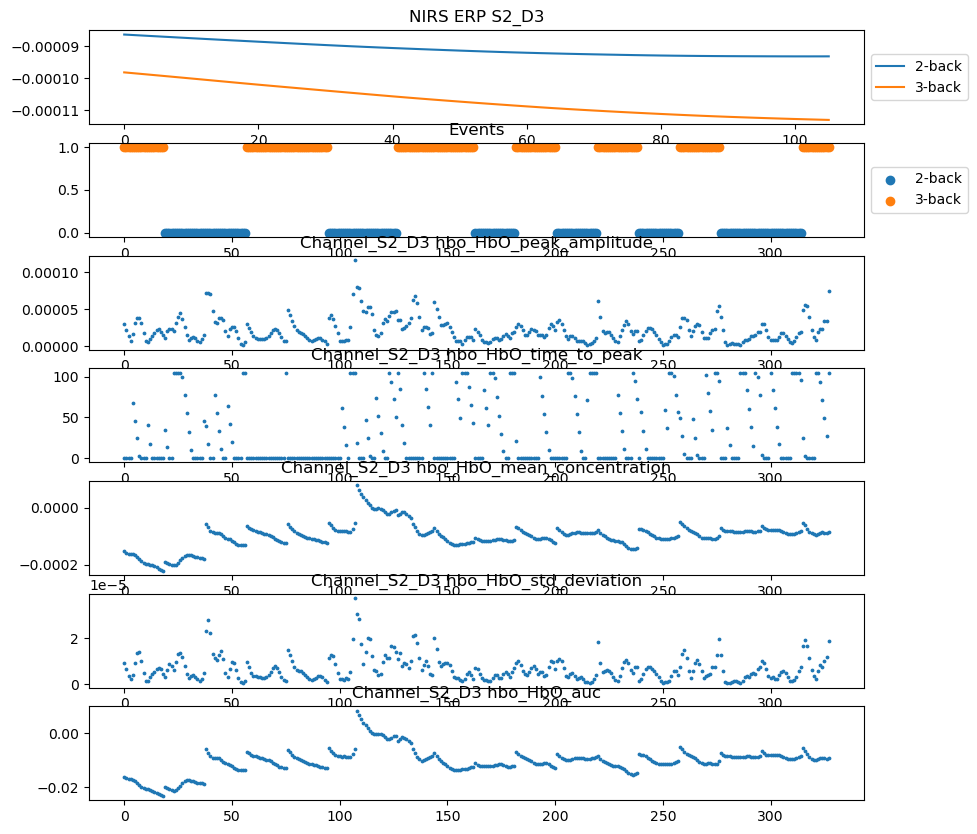

S9_D9 hbo


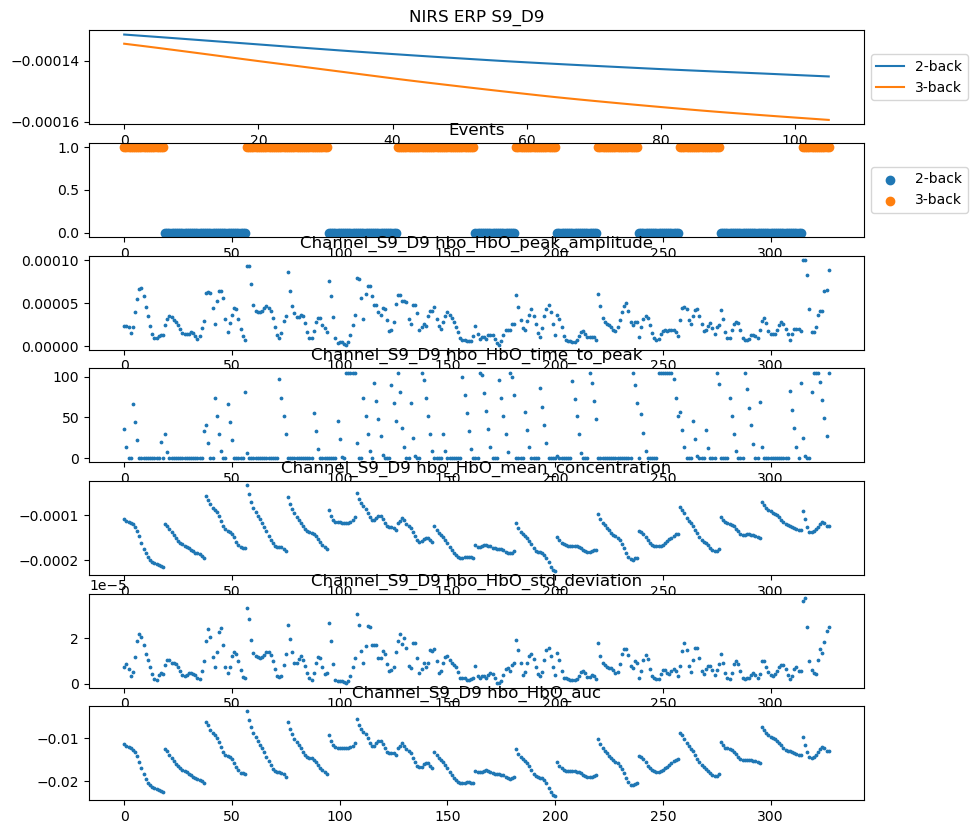

S9_D10 hbo


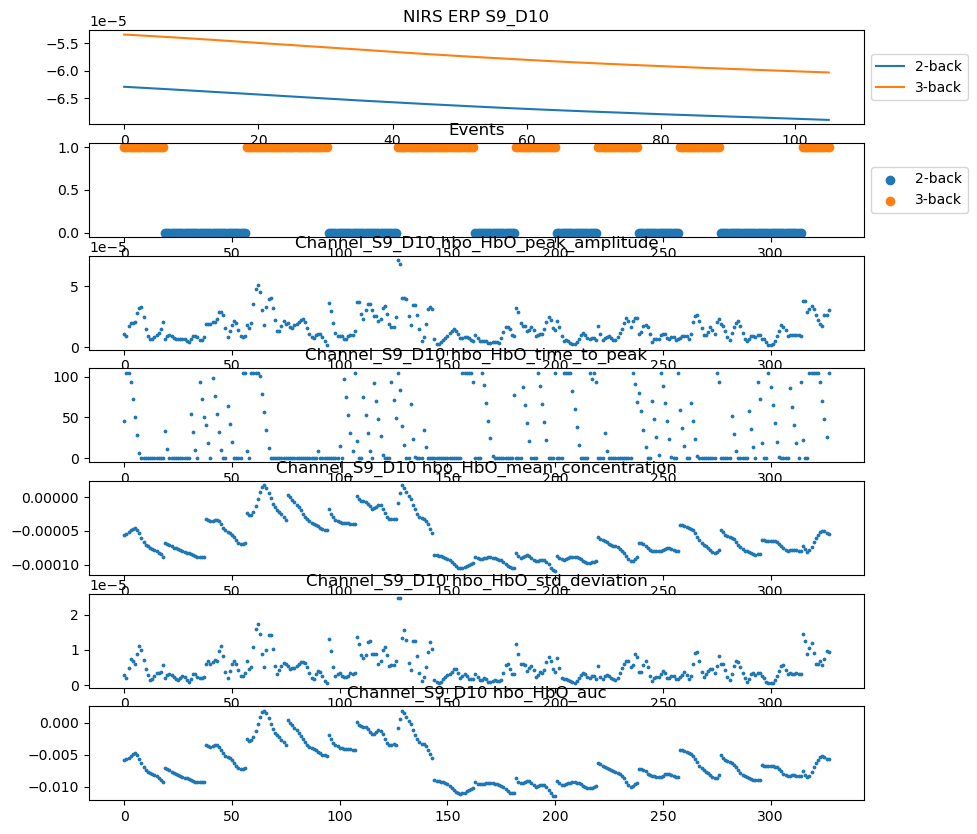

S10_D9 hbo


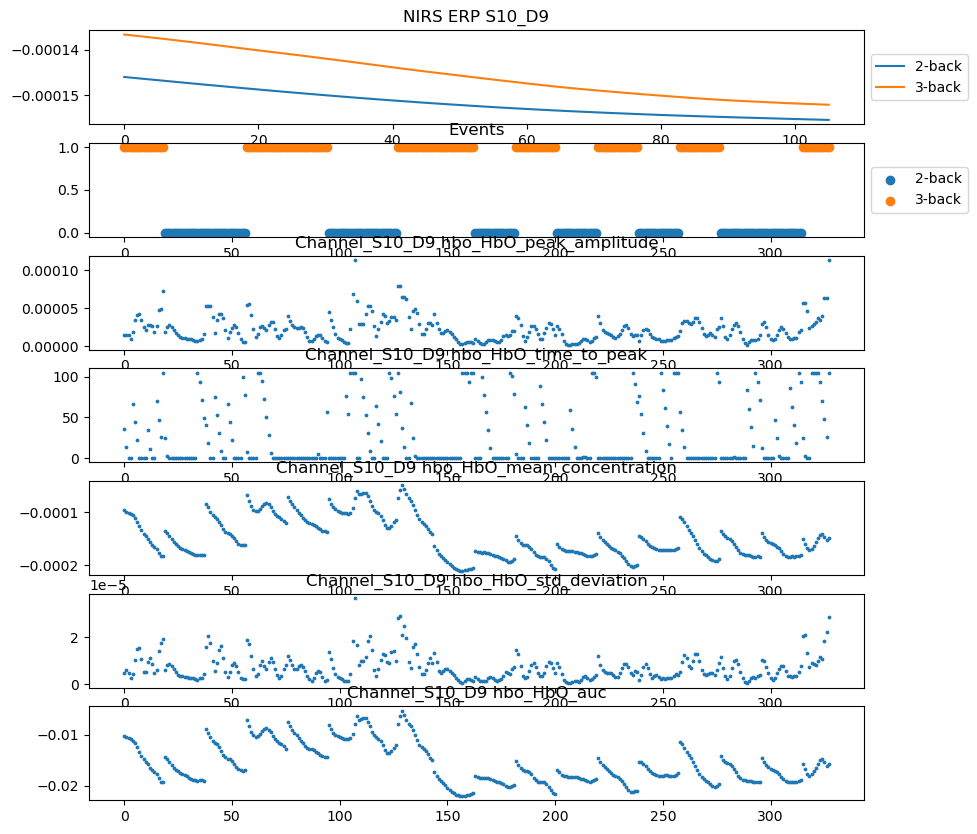

S10_D10 hbo


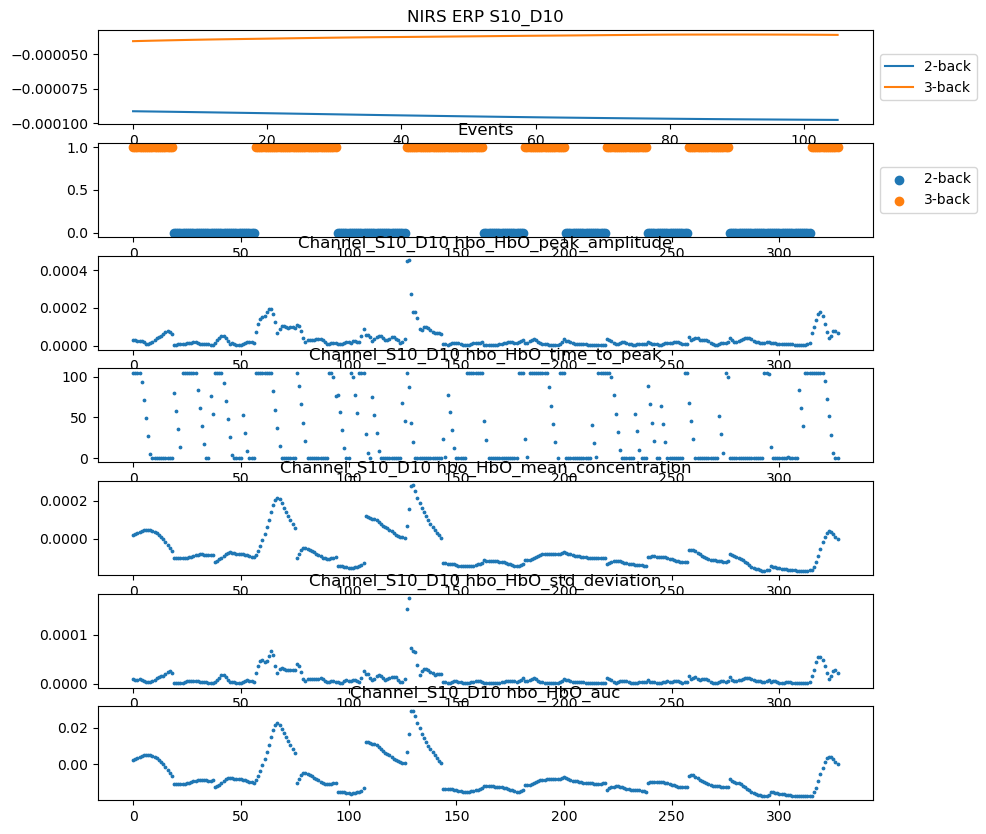

In [16]:
# NIRS
for channel_index, channel_name_with_type in enumerate(nirs_channels_to_use):
    print(channel_name_with_type)
    channel_name, hemo_type = channel_name_with_type.split(' ')
    hemo_index = 0 if hemo_type == 'hbo' else 1

    nirs_segmented_channel = nirs_segmented.copy()[channel_index, :, hemo_index]
    nirs_segmented_channel = np.expand_dims(nirs_segmented_channel, axis=0)

    plot_nirs_features(nirs_segmented_channel,
                       event_labels, 
                       nirs_feature_matrix, 
                       stims, 
                       legend_labels=legend_labels, 
                       channel_name=channel_name)

In [17]:
def predict_events(eeg_feature_matrix, nirs_feature_matrix, event_labels, stims, eeg_segmented, nirs_segmented):   
    # X = np.hstack((eeg_feature_matrix.to_numpy(), nirs_feature_matrix.to_numpy()))
    # X = eeg_feature_matrix.to_numpy()
    X = nirs_feature_matrix.to_numpy()
    feature_labels = eeg_feature_matrix.columns.to_list() + nirs_feature_matrix.columns.to_list()
    y = event_labels

    # get counts
    uniue_labels, counts = np.unique(y, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    # balance
    over = SMOTE(random_state=42, sampling_strategy='auto')
    under = RandomUnderSampler(random_state=42, sampling_strategy='auto')
    # apply balance
    X, y = over.fit_resample(X, y)

    uniue_labels, counts = np.unique(y, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    # Get data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

    # Select the top k features based on mutual information
    k = 100  # Number of features to select
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    # The selector object now contains the information about which features were selected
    selected_features = selector.get_support(indices=True)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    n_features = X_train.shape[1]
    n_classes = np.unique(y).size

    print(f'n_features: {n_features}')
    print(f'n_classes: {n_classes}')

    svm_model = SVC(kernel='linear', C=1.0)  # Start with a linear kernel and default C value
    svm_model.fit(X_train, y_train)

    X_test_temp = X_test.copy()
    y_test_temp = y_test.copy()

    y_pred = svm_model.predict(X_test_temp)
    print(f"Accuracy: {accuracy_score(y_test_temp, y_pred)}")
    print(classification_report(y_test_temp, y_pred))

predict_events(eeg_feature_matrix, nirs_feature_matrix, event_labels, stims, eeg_segmented, nirs_segmented)

Unique labels: [(0, 165), (1, 163)]
Unique labels: [(0, 165), (1, 165)]
n_features: 37
n_classes: 2
Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.89      0.94      0.91        33

    accuracy                           0.91        66
   macro avg       0.91      0.91      0.91        66
weighted avg       0.91      0.91      0.91        66



/Users/mm/anaconda3/envs/sr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=37. All the features will be returned.
  warnings.warn(


## Signal Prediction ##

### Parameters - Signal Prediction

In [18]:
# Time window (seconds)
eeg_t_min = -0.1
eeg_t_max = 0.9
nirs_t_min = 0
nirs_t_max = 15

offset_t = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
n_epochs = 100

# Define channels to use
# nirs_channels_to_use_base = list(NIRS_COORDS.keys())
use_hbr = False
nirs_channels_to_use_base = ['AF7','AFF5', 'AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
# eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channels_to_use = ['Cz', 'P7']

### Extract Data ###

In [19]:
# Generator function to get data
def align_eeg_nirs(
                upscale_rate, 
                hb_data, 
                eeg_data,
                do_interpolation=False,
                do_zscore_normilization=False):
    x_full = hb_data
    y_full = eeg_data

    # Perform time correction
    y_length = y_full.shape[1]

    # Find the nearest lower and higher multiples of upscale_rate
    lower_multiple = y_length - (y_length % upscale_rate)
    higher_multiple = lower_multiple + upscale_rate if y_length % upscale_rate != 0 else lower_multiple
    exact_multiple = upscale_rate*x_full.shape[1]

    # Determine which multiple is closest to the original length
    y_new_length = higher_multiple
    if (y_length - lower_multiple) <= (higher_multiple - y_length):
        y_new_length = lower_multiple
    # Check if the new length is longer than the fnirs data and adjust
    if exact_multiple < y_new_length:
        y_new_length = exact_multiple
    else:
        x_full = x_full[:,:int(y_new_length/upscale_rate)]

    y_full = y_full[:,:y_new_length] # make eeg upscale rate times longer

    if do_interpolation:
        print(f'x {x_full.shape}')
        print(f'y {y_full.shape}')
        
        # We need to interpolate nirs to have the same number of points as eeg
        nirs_old = np.linspace(0, 1, x_full.shape[1])  # Original sampling points for nirs
        nirs_new = np.linspace(0, 1, y_full.shape[1])  # New sampling points to match the length of eeg

        # Perform cubic interpolation
        x_full_new = np.zeros((x_full.shape[0], y_full.shape[1]))
        for channel in range(x_full.shape[0]):
            cs = CubicSpline(nirs_old, x_full[channel])
            x_full_new[channel] = cs(nirs_new)

        x_full = x_full_new

    if do_zscore_normilization:
        z_sigma_max=3200
        # z_sigma_max=2200
        z_sigma_min=1

        segment_size = 10000
        y_full_segment = []
        for i in range(0, y_full.shape[1], segment_size):
            # y_full_segment = spatial_zscore(y_full,z_sigma_max)-spatial_zscore(y_full,z_sigma_min)
            y_full_segment.append(spatial_zscore(y_full[:,i:i+segment_size],z_sigma_max)-spatial_zscore(y_full[:,i:i+segment_size],z_sigma_min))

        y_full = np.hstack(y_full_segment)

    return x_full, y_full

def window_eeg_nirs(upscale_rate,
                    hb_data, 
                    eeg_data, 
                    nirs_i_min, 
                    nirs_i_max, 
                    eeg_i_min, 
                    eeg_i_max,
                    offset=0):
    
    print(f'hb_data: {hb_data.shape}')
    print(f'eeg_data: {eeg_data.shape}')

    # Ensure windows are within bounds
    # hb_end_index = hb_data.shape[1] - nirs_i_max - offset
    # eeg_end_index = eeg_data.shape[1] - eeg_i_max
    # end_index = np.min([hb_end_index, eeg_end_index])
    end_index = 100000

    hb_start_index = nirs_i_min + offset
    eeg_start_index = eeg_i_min
    min = np.min([hb_start_index, eeg_start_index])
    start_index = np.abs(min)

    windowed_hb_data = []
    windowed_eeg_data = []
    for i in range(start_index, end_index):
        # EEG
        # eeg_low_index = i + eeg_i_min
        # eeg_high_index = i + eeg_i_max
        # windowed_eeg_data.append(eeg_data[:,eeg_low_index:eeg_high_index])

        # Nirs
        nirs_low_index = int(np.round(i/upscale_rate)) + nirs_i_min + offset
        nirs_high_index = int(np.round(i/upscale_rate)) + nirs_i_max + offset
        windowed_hb_data.append(hb_data[:,nirs_low_index:nirs_high_index])
        

    windowed_hb_data = np.array(windowed_hb_data)
    # windowed_eeg_data = np.array(windowed_eeg_data)
    windowed_eeg_data = eeg_data[:,start_index:end_index].transpose(1,0)
    
    return windowed_hb_data, windowed_eeg_data

def get_xy_signal_prediction(hbo_mne, 
                            hbr_mne, 
                            eeg_mne,
                            nirs_t_min, 
                            nirs_t_max,
                            eeg_t_min, 
                            eeg_t_max,
                            offset_t=0,
                            use_hbr=True):
    
    do_interpolation = False
    do_zscore_normilization = True
    
    fnirs_sampling_rate = hbo_mne.info['sfreq']
    eeg_sample_rate = eeg_mne.info['sfreq']
    upscale_rate = int(np.rint(eeg_sample_rate/fnirs_sampling_rate))

    if do_interpolation:
        fnirs_sampling_rate = eeg_sample_rate
    
    # convert index to times
    nirs_i_min = int(nirs_t_min*fnirs_sampling_rate)
    nirs_i_max = int(nirs_t_max*fnirs_sampling_rate)
    eeg_i_min = int(eeg_t_min*eeg_sample_rate)
    eeg_i_max = int(eeg_t_max*eeg_sample_rate)

    offset_i = int(offset_t*fnirs_sampling_rate)

    # Get all data
    y_full = eeg_mne.get_data()
    x_full = np.vstack([hbo_mne.get_data(), hbr_mne.get_data()]) if use_hbr else hbo_mne.get_data()

    if do_interpolation or do_zscore_normilization:
        x_full, y_full = align_eeg_nirs(
                                    upscale_rate, 
                                    x_full, 
                                    y_full,
                                    do_interpolation=do_interpolation,
                                    do_zscore_normilization=do_zscore_normilization)

        print(f'x_z inter: {x_full.shape}')
        print(f'y_z inter: {y_full.shape}')
        if do_interpolation:
            upscale_rate = 1

    # Window data
    x_full, y_full = window_eeg_nirs(
                                    upscale_rate, 
                                    x_full, 
                                    y_full,
                                    nirs_i_min,
                                    nirs_i_max, 
                                    eeg_i_min, 
                                    eeg_i_max,
                                    offset=offset_i)

    print(f'x_z final: {x_full.shape}')
    print(f'y_z final: {y_full.shape}')

    epoch_count = x_full.shape[0]
    participant_id = [1]*epoch_count
    temporal_id = np.arange(epoch_count)
    nirs_meta_data_dict = {
        'participant_id': participant_id,
        'temporal_id': temporal_id
    }

    epoch_count = y_full.shape[0]
    participant_id = [1]*epoch_count
    temporal_id = np.arange(epoch_count)
    eeg_meta_data_dict = {
        'participant_id': participant_id,
        'temporal_id': temporal_id
    }


    return x_full, y_full, nirs_meta_data_dict, eeg_meta_data_dict


Channel name AFp5h not found in NIRS_COORDS
['S1_D1', 'S1_D2', 'S2_D3', 'S9_D9', 'S9_D10', 'S10_D9', 'S10_D10']
['S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', 'S1_D14 hbo', 'S1_D14 hbr', 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D3 hbo', 'S2_D3 hbr', 'S3_D1 hbo', 'S3_D1 hbr', 'S3_D2 hbo', 'S3_D2 hbr', 'S3_D3 hbo', 'S3_D3 hbr', 'S3_D4 hbo', 'S3_D4 hbr', 'S4_D2 hbo', 'S4_D2 hbr', 'S4_D4 hbo', 'S4_D4 hbr', 'S4_D5 hbo', 'S4_D5 hbr', 'S5_D3 hbo', 'S5_D3 hbr', 'S5_D4 hbo', 'S5_D4 hbr', 'S5_D6 hbo', 'S5_D6 hbr', 'S6_D4 hbo', 'S6_D4 hbr', 'S6_D5 hbo', 'S6_D5 hbr', 'S6_D6 hbo', 'S6_D6 hbr', 'S6_D7 hbo', 'S6_D7 hbr', 'S7_D5 hbo', 'S7_D5 hbr', 'S7_D7 hbo', 'S7_D7 hbr', 'S7_D10 hbo', 'S7_D10 hbr', 'S8_D6 hbo', 'S8_D6 hbr', 'S8_D7 hbo', 'S8_D7 hbr', 'S9_D7 hbo', 'S9_D7 hbr', 'S9_D9 hbo', 'S9_D9 hbr', 'S9_D10 hbo', 'S9_D10 hbr', 'S10_D9 hbo', 'S10_D9 hbr', 'S10_D10 hbo', 'S10_D10 hbr', 'S10_D11 hbo', 'S10_D11 hbr', 'S10_D12 hbo', 'S10_D12 hbr', 'S11_D5 hbo', 'S11_D5 hbr', 'S11_D10 hbo', 'S11_D10 hbr', 'S1

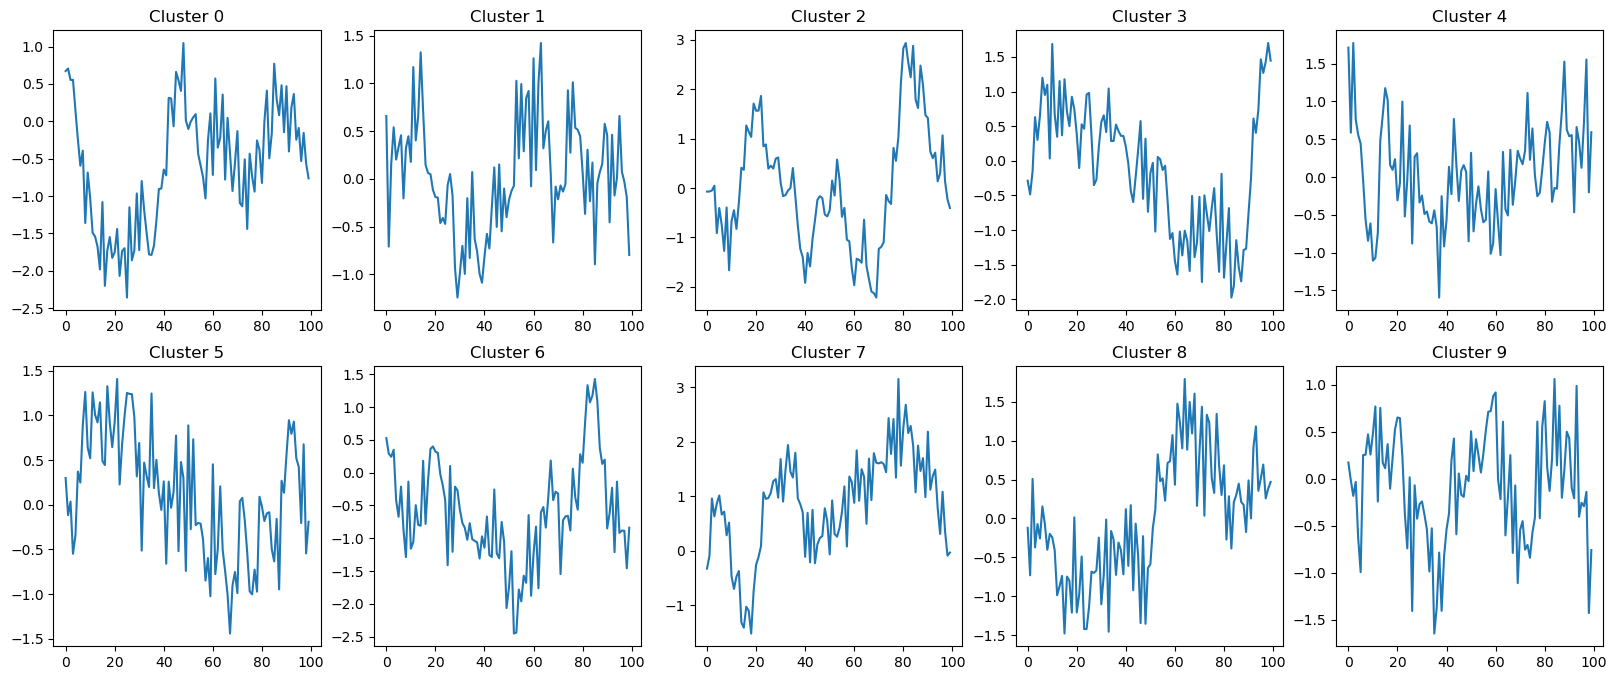

In [20]:
# Predict EEG

# Get NIRS channels to use
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(nirs_channels_to_use_base, NIRS_COORDS, nirs_processed_hemoglobin.ch_names)
print(nirs_channels_to_use_ids)
print(nirs_processed_hemoglobin.ch_names)

eeg_voltage_data = eeg_filtered_waves['full'].copy().pick(picks=eeg_channels_to_use)
if do_processing:
    nirs_channels_to_use_hbo = [f'{c} hbo' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} hbr' for c in nirs_channels_to_use_ids]
else:
    nirs_channels_to_use_hbo = [f'{c} 760' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} 850' for c in nirs_channels_to_use_ids]
    
hbo_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbo)
hbr_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbr)

# For labeling
nirs_channels_to_use = nirs_channels_to_use_base
# nirs_channels_to_use = [f'{c} hbo' for c in nirs_channels_to_use_ids]+[f'{c} hbr' for c in nirs_channels_to_use_ids]
if use_hbr:
    nirs_channels_to_use = nirs_channels_to_use_hbo+nirs_channels_to_use_hbr
else:
    nirs_channels_to_use = nirs_channels_to_use_hbo

# plot mne nirs
nirs_windowed_signal_prediction, eeg_windowed_signal_prediction, nirs_meta_data_dict, eeg_meta_data_dict = get_xy_signal_prediction(
                                                          hbo_data, 
                                                          hbr_data, 
                                                          eeg_voltage_data, 
                                                          nirs_t_min, 
                                                          nirs_t_max, 
                                                          eeg_t_min, 
                                                          eeg_t_max, 
                                                          offset_t, 
                                                          use_hbr=use_hbr)

print(eeg_windowed_signal_prediction.shape)
# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    plot_index = i*100
    axs[i//5, i%5].plot(eeg_windowed_signal_prediction[plot_index:plot_index+100,0])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

### EEG Decoder/Encoder ###

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Define the Encoder part of the VAE
# class EEG_Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, dropout_rate):
#         super(EEG_Encoder, self).__init__()
#         self.rnn = nn.GRU(input_dim, hidden_dim2, batch_first=True)
#         self.mu = nn.Linear(hidden_dim2, latent_dim)
#         self.log_var = nn.Linear(hidden_dim2, latent_dim)

#         print(f'input_dim: {input_dim}')
#         print(f'hidden_dim1: {hidden_dim1}')
#         print(f'hidden_dim2: {hidden_dim2}')
#         print(f'latent_dim: {latent_dim}')
#         print(f'dropout_rate: {dropout_rate}')
        
#     def forward(self, x):
#         _, h_n = self.rnn(x)  # h_n is the last hidden state
#         h_n = h_n.squeeze(0)  # Remove the first dimension for batch
#         return self.mu(h_n), self.log_var(h_n)

# Define the Decoder part of the VAE
# class EEG_Decoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, output_dim, sequence_length):
#         super(EEG_Decoder, self).__init__()
#         self.rnn = nn.GRU(latent_dim, hidden_dim, batch_first=True)
#         self.out = nn.Linear(hidden_dim, output_dim)
#         self.sequence_length = sequence_length

#         print(f'latent_dim: {latent_dim}')
#         print(f'hidden_dim: {hidden_dim}')
#         print(f'output_dim: {output_dim}')
#         print(f'sequence_length: {sequence_length}')

#     def forward(self, z):
#         # Repeat z to match the sequence length
#         # z = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
#         # output, _ = self.rnn(z)

#         z = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
#         output, _ = self.rnn(z)
#         # We take the output of the last LSTM time step
#         output = self.out(output[:, -1, :])

#         return torch.sigmoid(output)

# # Define the full VAE
# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, output_dim, sequence_length, dropout_rate):
#         super(VAE, self).__init__()
#         self.encoder = EEG_Encoder(input_dim, hidden_dim1, hidden_dim2, latent_dim, dropout_rate)
#         self.decoder = EEG_Decoder(latent_dim, hidden_dim2, output_dim, sequence_length)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         reconstruction = self.decoder(z)
#         return reconstruction, mu, log_var

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

    def reparameterize(self, x):
        self.latent_mean = self.mu(x)
        self.latent_log_var = self.log_var(x)

        if self.training:
            std = torch.exp(0.5 * self.latent_log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

    def forward(self, x):
        x=self.linear(x)
        x = torch.relu(x)
        z = self.reparameterize(x)

        return z, self.latent_mean, self.latent_log_var

# Define the Decoder part of the VAE
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, z):
        z = torch.relu(self.linear(z))
        return torch.sigmoid(self.out(z))  # Using sigmoid for normalization

# Define the full VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, output_dim, dropout_rate):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim)

        print(f'input_dim: {input_dim}')
        print(f'latent_dim: {latent_dim}')
    
    def forward(self, x):
        z, latent_mean, latent_log_var = self.encoder(x)
        return self.decoder(z), latent_mean, latent_log_var

(99980, 2)
x_train: (89982, 1)


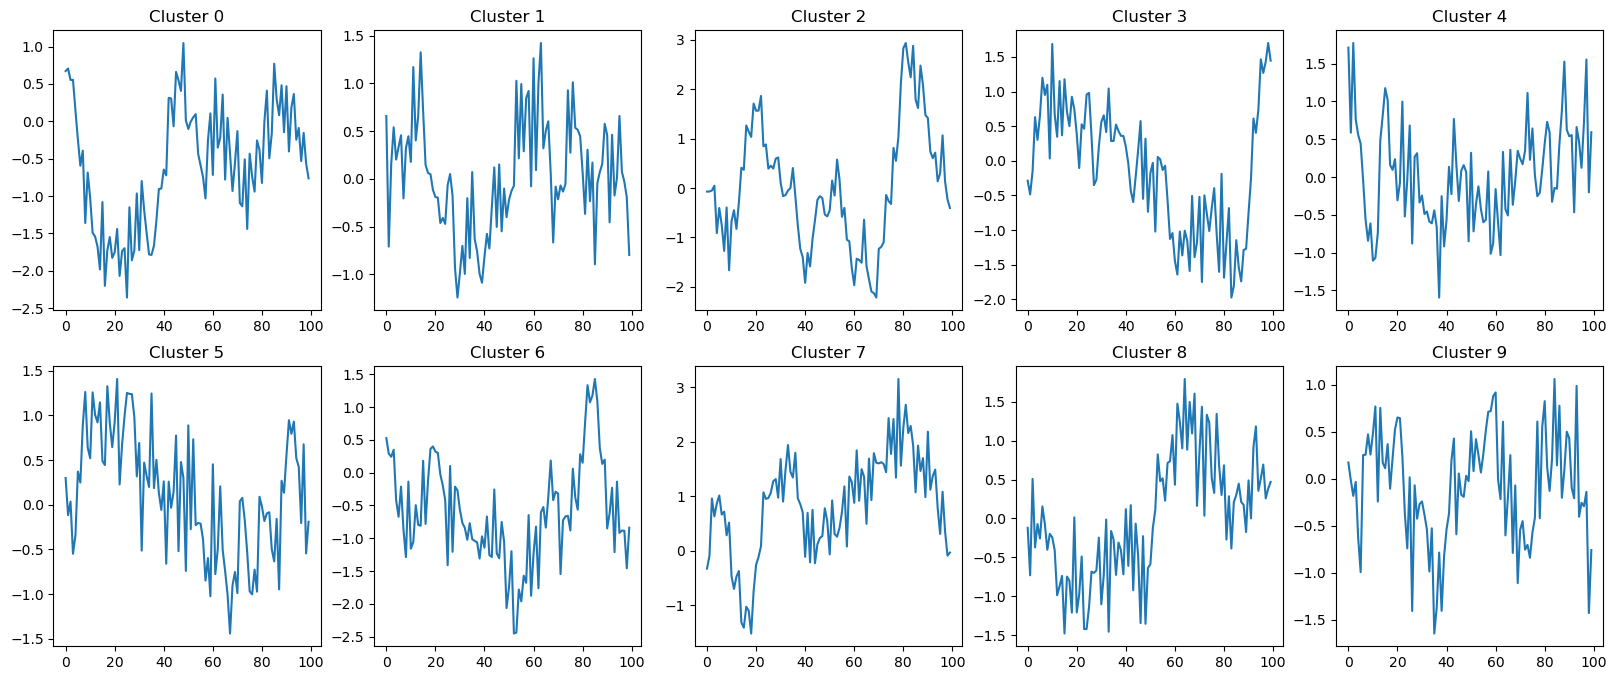

In [22]:
full_data = eeg_windowed_signal_prediction.copy()
print(full_data.shape)

test_size = int(full_data.shape[0] * 0.1)
train_size = full_data.shape[0] - test_size

# Train
# Assuming x_train contains the EEG data
# scaler = StandardScaler()  # or MinMaxScaler(feature_range=(0, 1))
# x_train_scaled = scaler.fit_transform(full_data.reshape(-1, 1))
# full_data = x_train_scaled.reshape(full_data.shape)

# add single dimension to match the input shape of the model
eeg_data_train = full_data[:train_size, 0]
eeg_data_train = np.expand_dims(eeg_data_train, axis=1)

print(f'x_train: {eeg_data_train.shape}')

# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    plot_index = i*100
    axs[i//5, i%5].plot(eeg_data_train[plot_index:plot_index+100, 0])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()


In [23]:
class CCALoss(nn.Module):
    def forward(self, X, Y):
        # Center the variables
        X = X - X.mean(0)
        Y = Y - Y.mean(0)

        # Compute covariance matrices
        covariance_XX = X.t().mm(X) / (X.size(0) - 1)
        covariance_YY = Y.t().mm(Y) / (Y.size(0) - 1)
        covariance_XY = X.t().mm(Y) / (X.size(0) - 1)

        # Solve the generalized eigenvalue problem for CCA
        inv_XX = torch.linalg.inv(covariance_XX)
        inv_YY = torch.linalg.inv(covariance_YY)
        matrix = inv_XX.mm(covariance_XY).mm(inv_YY).mm(covariance_XY.t())

        # Use torch to get the eigenvalues
        cca_loss = -torch.linalg.eigvals(matrix).abs().sum()
        return cca_loss
    
class CorrelationLoss(nn.Module):
    def __init__(self):
        super(CorrelationLoss, self).__init__()
        self.epsilon = 1e-8  # Small constant to avoid division by zero

    def forward(self, x, y):
        x_mean = x - x.mean(dim=0, keepdim=True)
        y_mean = y - y.mean(dim=0, keepdim=True)
        
        # Calculate the standard deviations, adding epsilon for numerical stability
        x_std = x.std(dim=0, keepdim=True) + self.epsilon
        y_std = y.std(dim=0, keepdim=True) + self.epsilon

        # Compute the covariance between x and y
        covariance = (x_mean * y_mean).mean(dim=0)

        # Compute the correlation matrix and then the mean of the correlation coefficients
        correlation_matrix = covariance / (x_std * y_std)
        correlation_loss = 1 - correlation_matrix.mean()  # We aim to maximize correlation, hence minimize (1 - corr)
        return correlation_loss

# Adding a simple contrastive loss component
def contrastive_loss_2(z, participants, temporal_ids, alpha=0.1):
    """
    A simple contrastive loss that encourages closer encoding for similar conditions.
    """
    n = z.size(0)
    loss = 0.0
    count = 0

    # Simple pairwise loss: for each pair in the batch
    for i in range(n):
        for j in range(i + 1, n):
            # Calculate the Euclidean distance between two latent vectors
            latent_dist = F.pairwise_distance(z[i].unsqueeze(0), z[j].unsqueeze(0))

            # Determine if they are from the same participant
            same_participant = participants[i] == participants[j]

            # Calculate distance between two vectors
            # spatial_dist = F.pairwise_distance(spatial_coordinates[i].unsqueeze(0), spatial_coordinates[j].unsqueeze(0))
            temporal_dist = torch.abs(temporal_ids[i] - temporal_ids[j])

            # Calculate a combined spatial-temporal weight
            # Larger spatial or temporal distances increase the desired separation in the latent space
            weight = torch.exp(-alpha * temporal_dist)

            # Loss contribution depends on whether pairs are from the same participant
            if same_participant:
                # Minimize the latent distance for similar conditions
                loss += weight * latent_dist
            else:
                # Maximize the latent distance for different conditions, ensuring at least some minimal separation
                loss += weight * F.relu(1.0 - latent_dist)

            count += 1

    return loss / count if count > 0 else 0

In [24]:
# Train
eeg_y_train = torch.from_numpy(eeg_data_train).float()
eeg_x_train = torch.from_numpy(eeg_data_train).float()

# Get meta data from features  # EEG data needs to be float
participants = torch.tensor(eeg_meta_data_dict['participant_id'][:train_size], dtype=torch.long)  # Participant IDs as long integers
# spatial_distances = torch.tensor(spatial_distances, dtype=torch.float32)  # Continuous data
temporal_distances = torch.tensor(eeg_meta_data_dict['temporal_id'][:train_size], dtype=torch.long)
# Stack participant and distance information along the second dimension
meta_data = torch.stack([participants, temporal_distances], dim=1)

print(f'x_train: {eeg_x_train.shape}')
print(f'y_train: {eeg_y_train.shape}')
print(f'meta_data: {meta_data.shape}')

# Stack participant and distance information along the second dimension
train_dataset = TensorDataset(eeg_x_train, eeg_y_train, meta_data)
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)

# Assuming each EEG window is flattened into a vector
input_dim = eeg_x_train.shape[1] # number of features in each time point
latent_dim = 50  # Size of the latent vector

# Create the model, optimizer, and loss function
eeg_model = VAE(input_dim, 
                hidden_dim1=128,
                hidden_dim2=64, 
                latent_dim=latent_dim, 
                output_dim=input_dim,
                dropout_rate=0.2)

# from torchmetrics.functional import r2_score
from torchmetrics.regression import R2Score

optimizer = optim.Adam(eeg_model.parameters(), lr=0.01)
# reconstruction_loss = nn.MSELoss()
# reconstruction_loss = R2Score(num_outputs=sequence_length)
reconstruction_loss = nn.MSELoss(size_average=False)

# Modify the training loop to include the contrastive loss
def train(epoch):
    eeg_model.train()
    train_loss = 0
    for batch_idx, (data, targets, meta_data) in enumerate(train_loader):
        # data = data.to(device)
        optimizer.zero_grad()
        reconstructed, mu, log_var = eeg_model(data)
        
        # recon_loss = F.mse_loss(reconstructed, targets, reduction='sum')
        # recon_loss = torch.abs(1-reconstruction_loss(targets, reconstructed))

        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        recon_loss = reconstruction_loss(reconstructed, data)

        # Assume targets contain [participants, spatial_distances, temporal_distances]
        participants = meta_data[:,0]
        temporal_distances = meta_data[:, 1]
        # spatial_distances = meta_data[:, 2]

        # cont_loss = contrastive_loss(mu, participants, temporal_distances)

        # Combine the losses
        loss = recon_loss + kl_loss
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return eeg_model


# Example of training the model for 5 epochs
for epoch in range(1, 10):
    eeg_model = train(epoch)

eeg_encoder = eeg_model.encoder
eeg_decoder = eeg_model.decoder

x_train: torch.Size([89982, 1])
y_train: torch.Size([89982, 1])
meta_data: torch.Size([89982, 2])
input_dim: 1
latent_dim: 50


/Users/mm/anaconda3/envs/sr/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/89982 (0%)]	Loss: 1.090832
Train Epoch: 1 [5000/89982 (6%)]	Loss: 0.542663
Train Epoch: 1 [10000/89982 (11%)]	Loss: 0.435827
Train Epoch: 1 [15000/89982 (17%)]	Loss: 0.452072
Train Epoch: 1 [20000/89982 (22%)]	Loss: 0.416416
Train Epoch: 1 [25000/89982 (28%)]	Loss: 0.378220
Train Epoch: 1 [30000/89982 (33%)]	Loss: 0.518520
Train Epoch: 1 [35000/89982 (39%)]	Loss: 0.425793
Train Epoch: 1 [40000/89982 (44%)]	Loss: 0.445457
Train Epoch: 1 [45000/89982 (50%)]	Loss: 0.513012
Train Epoch: 1 [50000/89982 (56%)]	Loss: 0.407882
Train Epoch: 1 [55000/89982 (61%)]	Loss: 0.425696
Train Epoch: 1 [60000/89982 (67%)]	Loss: 0.441124
Train Epoch: 1 [65000/89982 (72%)]	Loss: 0.472623
Train Epoch: 1 [70000/89982 (78%)]	Loss: 0.465731
Train Epoch: 1 [75000/89982 (83%)]	Loss: 0.479539
Train Epoch: 1 [80000/89982 (89%)]	Loss: 0.479536
Train Epoch: 1 [85000/89982 (94%)]	Loss: 0.433684
====> Epoch: 1 Average loss: 0.4592
Train Epoch: 2 [0/89982 (0%)]	Loss: 0.533811
Train Epoch: 2 [5000/89982

(99980, 150, 7)


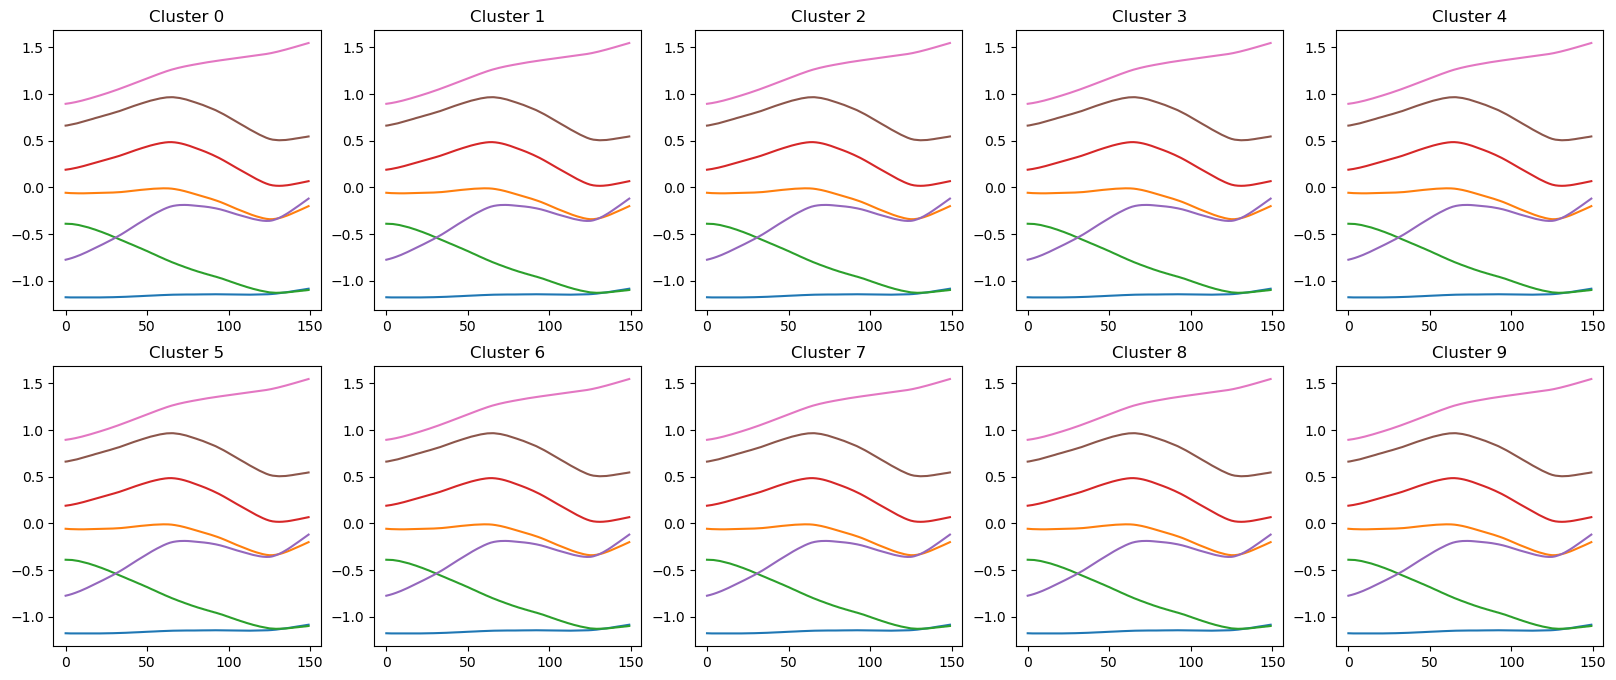

x_train: torch.Size([89982, 150, 7])
eeg_x_train torch.Size([89982, 1])


In [25]:
# nirs_full_data = nirs_windowed_signal_prediction.copy()
# 0,1,2 -> 0,2,1
nirs_full_data = nirs_windowed_signal_prediction.transpose(0,2,1)

print(nirs_full_data.shape)# epochs, window, channels

# scale for each channel
for i in range(nirs_full_data.shape[2]):
    nirs_full_data[:,:,i] = StandardScaler().fit_transform(nirs_full_data[:,:,i])

# Train
nirs_data_train = nirs_full_data[:train_size]

# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    axs[i//5, i%5].plot(nirs_full_data[i])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

nirs_x_train = torch.from_numpy(nirs_data_train).float()

print(f'x_train: {nirs_x_train.shape}')
print(f'eeg_x_train {eeg_x_train.shape}')

# Get meta data from features  # EEG data needs to be float
nirs_participants = torch.tensor(nirs_meta_data_dict['participant_id'][:train_size], dtype=torch.long)  # Participant IDs as long integers
# spatial_distances = torch.tensor(spatial_distances, dtype=torch.float32)  # Continuous data
nirs_temporal_distances = torch.tensor(nirs_meta_data_dict['temporal_id'][:train_size], dtype=torch.long)
# Stack participant and distance information along the second dimension
nirs_meta_data = torch.stack([nirs_participants, nirs_temporal_distances], dim=1)

# Random data for testing
# nirs_x_train = torch.randn(nirs_x_train.shape)
# nirs_x_train = eeg_x_train

# Stack participant and distance information along the second dimension
nirs_train_dataset = TensorDataset(nirs_x_train, nirs_x_train, nirs_meta_data)
encoder_alignment_train_dataset = TensorDataset(nirs_x_train, eeg_x_train, nirs_meta_data)

In [27]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

hidden_size = 90
hidden_layer_depth = 1
latent_length = 50
batch_size = 500
learning_rate = 0.005
n_epochs = 10
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

sequence_length = nirs_x_train.shape[1]
number_of_features = nirs_x_train.shape[2]
print(nirs_x_train.shape)

nirs_vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block)

nirs_vrae.fit(nirs_train_dataset)



torch.Size([89982, 150, 7])
Epoch: 0
Batch 30, loss = 324286.6562, recon_loss = 324285.2500, kl_loss = 1.4035
Batch 60, loss = 320883.8438, recon_loss = 320881.6250, kl_loss = 2.2063
Batch 90, loss = 259144.9531, recon_loss = 259142.6406, kl_loss = 2.3057
Batch 120, loss = 266857.7812, recon_loss = 266851.8438, kl_loss = 5.9435
Batch 150, loss = 270196.5625, recon_loss = 270189.7188, kl_loss = 6.8348
Average loss: 295227.4127
Epoch: 1
Batch 30, loss = 254786.5469, recon_loss = 254778.6875, kl_loss = 7.8638
Batch 60, loss = 239522.4375, recon_loss = 239514.4688, kl_loss = 7.9646
Batch 90, loss = 228626.0000, recon_loss = 228619.1562, kl_loss = 6.8485
Batch 120, loss = 235955.6250, recon_loss = 235949.5000, kl_loss = 6.1249
Batch 150, loss = 193011.8906, recon_loss = 193005.8125, kl_loss = 6.0808
Average loss: 230114.3185
Epoch: 2
Batch 30, loss = 197734.4844, recon_loss = 197729.5156, kl_loss = 4.9659
Batch 60, loss = 193172.9062, recon_loss = 193168.0938, kl_loss = 4.8197
Batch 90, los

In [28]:
nirs_test_data = nirs_full_data[train_size:train_size+test_size]

print(nirs_test_data.shape)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()
test_dataset = TensorDataset(nirs_x_test, nirs_x_test)
nirs_predicted_nirs = nirs_vrae.reconstruct(test_dataset).transpose(1,0,2)

epoch_to_plot = 1
size = 100

(9998, 150, 7)


(9998, 150, 7)
(9500, 150, 7)
nirs 0 r2: -2.9295499636584252
nirs 1 r2: -0.23092681454119202
nirs 2 r2: -0.449576206535123
nirs 3 r2: -0.06311729415426393
nirs 4 r2: -1.1116294203602237
nirs 5 r2: -0.13956874175343348
nirs 6 r2: -0.13995141412808643


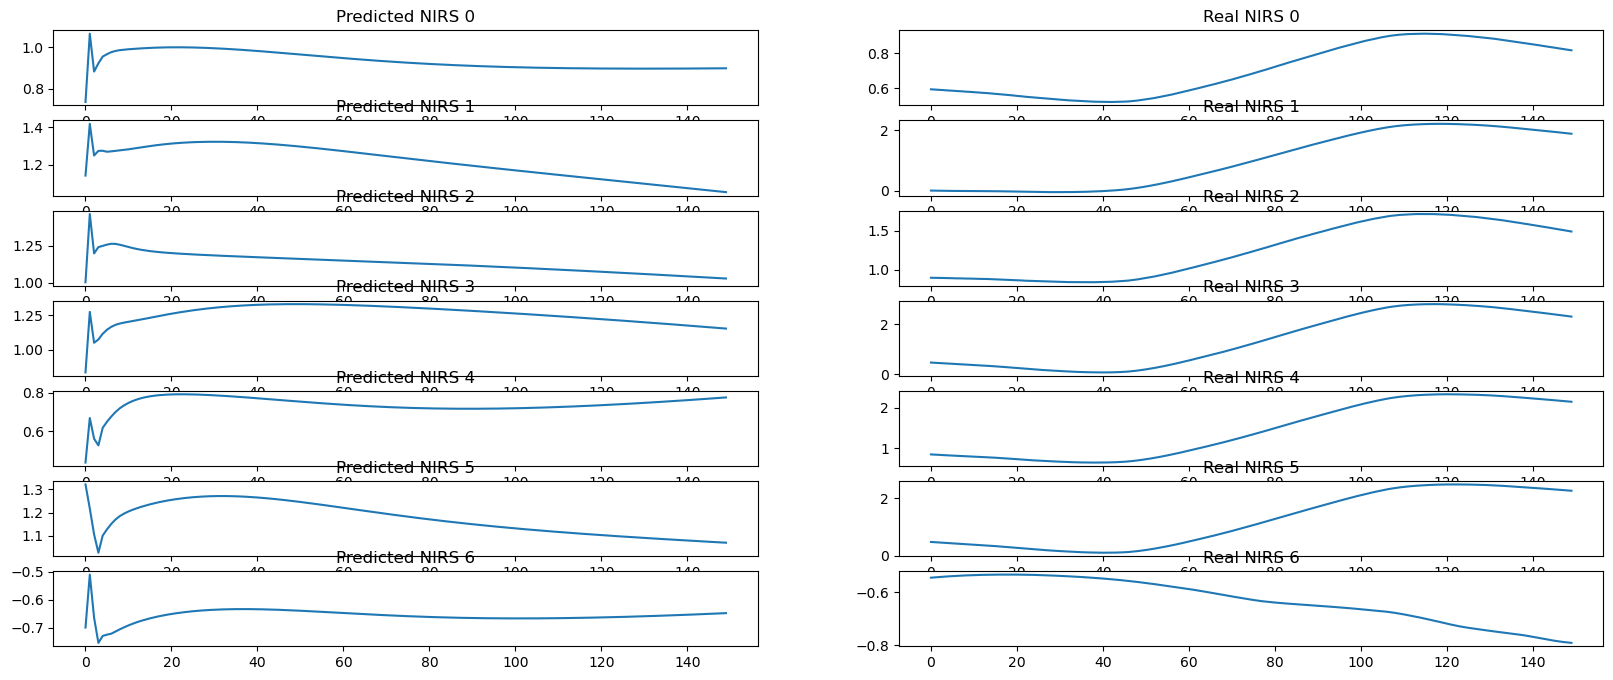

In [32]:
print(nirs_test_data.shape)
print(nirs_predicted_nirs.shape)

epoch_to_plot = 5000
time_window_count = 4

from sklearn.metrics import r2_score
# for each channel (7)
for i in range(nirs_test_data.shape[2]):
    r2_nirs = r2_score(nirs_test_data[epoch_to_plot,:,i], nirs_predicted_nirs[epoch_to_plot,:,i])
    print(f'nirs {i} r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
# plots should be for each channel 7,2
fig, axs = plt.subplots(7, 2, figsize=(20, 8))
for i in range(7):
    axs[i, 0].plot(nirs_predicted_nirs[epoch_to_plot,:,i])
    axs[i, 0].set_title(f'Predicted NIRS {i}')
    axs[i, 1].plot(nirs_test_data[epoch_to_plot,:,i])
    axs[i, 1].set_title(f'Real NIRS {i}')

plt.show()

In [33]:
nirs_latents = nirs_vrae.transform(encoder_alignment_train_dataset)
nirs_latents = torch.from_numpy(nirs_latents).float()
print(nirs_latents.shape)
print(eeg_x_train.shape)
print(nirs_meta_data.shape)

latent_train_dataset = TensorDataset(nirs_latents, eeg_x_train[:nirs_latents.shape[0]], nirs_meta_data[:nirs_latents.shape[0]])

print(nirs_latents.shape)

torch.Size([89500, 50])
torch.Size([89982, 1])
torch.Size([89982, 2])
torch.Size([89500, 50])


In [35]:
# Aligning the fNIRS encoder
def train_nirs_encoder(mapping_model, optimizer, eeg_encoder, nirs_vrae, train_loader, num_epochs=10):
    nirs_vrae.eval() # Make sure the NIRS encoder does not train 
    eeg_encoder.eval()  # Make sure the EEG encoder does not train   
    mapping_model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = nn.MSELoss()
    loss_fn = CorrelationLoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_latents, eeg_data, meta_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            with torch.no_grad():
                eeg_latents, eeg_mu, eeg_log_var = eeg_encoder(eeg_data)
            # nirs_latents = nirs_vrae.transform(fnirs_data)

            # Forward pass through the mapping model
            predicted_EEG_latent = mapping_model(nirs_latents)

            # Loss calculation (e.g., MSE)
            loss = loss_fn(predicted_EEG_latent, eeg_latents)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_latents.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_latents.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return mapping_model


mapping_model = nn.Linear(latent_length, latent_dim)
optimizer = optim.Adam(mapping_model.parameters(), lr=0.005)

num_epochs = 20
batch_size = 500

print(f'NIRS latents: {latent_length} EEG latents: {latent_dim}')
latent_train_loader = DataLoader(latent_train_dataset, batch_size=batch_size, shuffle=True)

mapping_model = train_nirs_encoder(mapping_model, optimizer, eeg_encoder, nirs_vrae, latent_train_loader, num_epochs=n_epochs)


NIRS latents: 50 EEG latents: 50
Train Epoch: 0 [0/89500 (0%)]	Loss: 0.002015
Train Epoch: 0 [5000/89500 (6%)]	Loss: 0.002053
Train Epoch: 0 [10000/89500 (11%)]	Loss: 0.001982
Train Epoch: 0 [15000/89500 (17%)]	Loss: 0.001949
Train Epoch: 0 [20000/89500 (22%)]	Loss: 0.001984
Train Epoch: 0 [25000/89500 (28%)]	Loss: 0.002034
Train Epoch: 0 [30000/89500 (34%)]	Loss: 0.001997
Train Epoch: 0 [35000/89500 (39%)]	Loss: 0.001931
Train Epoch: 0 [40000/89500 (45%)]	Loss: 0.001986
Train Epoch: 0 [45000/89500 (50%)]	Loss: 0.002008
Train Epoch: 0 [50000/89500 (56%)]	Loss: 0.001992
Train Epoch: 0 [55000/89500 (61%)]	Loss: 0.002065
Train Epoch: 0 [60000/89500 (67%)]	Loss: 0.001982
Train Epoch: 0 [65000/89500 (73%)]	Loss: 0.002073
Train Epoch: 0 [70000/89500 (78%)]	Loss: 0.001927
Train Epoch: 0 [75000/89500 (84%)]	Loss: 0.002010
Train Epoch: 0 [80000/89500 (89%)]	Loss: 0.001952
Train Epoch: 0 [85000/89500 (95%)]	Loss: 0.002055
Train Epoch: 1 [0/89500 (0%)]	Loss: 0.001991
Train Epoch: 1 [5000/89500 (6

torch.Size([9500, 50])
torch.Size([9500, 50])
torch.Size([9998, 1])
(9998, 1)
(9998, 1)
(9500, 1)
nirs r2: -0.221628225407976, eeg r2: 0.7740486674343694


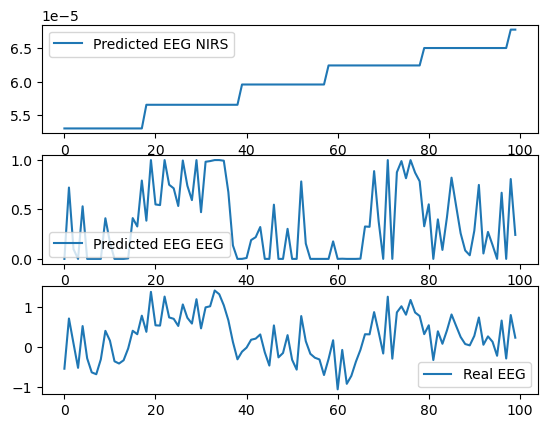

In [36]:
def predict_eeg_from_nirs(nirs_vrae, eeg_decoder, mapping_model, fnirs_data):
    nirs_vrae.eval()
    eeg_decoder.eval()
    mapping_model.eval()

    with torch.no_grad():
        nirs_latents = nirs_vrae.transform(fnirs_data)
        nirs_latents = torch.from_numpy(nirs_latents).float()
        print(nirs_latents.shape)
        eeg_latents = mapping_model(nirs_latents)
        print(eeg_latents.shape)
        predicted_eeg = eeg_decoder(eeg_latents)
    return nirs_latents.numpy(), predicted_eeg.numpy()

def predict_eeg_from_eeg(eeg_encoder, eeg_decoder, eeg_data):
    eeg_encoder.eval()
    eeg_decoder.eval()
    with torch.no_grad():
        eeg_z, latent_mean, latent_log_var = eeg_encoder(eeg_data)
        predicted_eeg = eeg_decoder(eeg_z)
    return eeg_z.numpy(), predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()
test_dataset = TensorDataset(nirs_x_test, nirs_x_test)
nirs_latents, nirs_predicted_eeg = predict_eeg_from_nirs(nirs_vrae, eeg_decoder, mapping_model, test_dataset)

eeg_test = torch.from_numpy(eeg_test_data).float()
eeg_latents, eeg_predicted_eeg = predict_eeg_from_eeg(eeg_encoder, eeg_decoder, eeg_test)
print(eeg_test.shape)

epoch_to_plot = 10
size = 100

print(eeg_test_data.shape)
print(eeg_predicted_eeg.shape)
print(nirs_predicted_eeg.shape)

from sklearn.metrics import r2_score
r2_nirs = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg[epoch_to_plot:epoch_to_plot+size])
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], eeg_predicted_eeg[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}, eeg r2: {r2_eeg}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(3)
axs[0].plot(nirs_predicted_eeg[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS')
axs[0].legend()
axs[1].plot(eeg_predicted_eeg[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG EEG')
axs[1].legend()
axs[2].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[2].legend()
plt.show()

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from plotly.graph_objs import *
import plotly

def plot_clustering(z_run, labels, engine ='plotly', download = False, folder_name ='clustering'):
    """
    Given latent variables for all timeseries, and output of k-means, run PCA and tSNE on latent vectors and color the points using cluster_labels.
    :param z_run: Latent vectors for all input tensors
    :param labels: Cluster labels for all input tensors
    :param engine: plotly/matplotlib
    :param download: If true, it will download plots in `folder_name`
    :param folder_name: Download folder to dump plots
    :return:
    """
    def plot_clustering_plotly(z_run, labels):

        labels = labels[:z_run.shape[0]]  # because of weird batch_size

        hex_colors = []
        for _ in np.unique(labels):
            hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

        colors = [hex_colors[int(i)] for i in labels]

        z_run_pca = TruncatedSVD(n_components=3).fit_transform(z_run)
        z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

        trace = Scatter(
            x=z_run_pca[:, 0],
            y=z_run_pca[:, 1],
            mode='markers',
            marker=dict(color=colors)
        )
        data = Data([trace])
        layout = Layout(
            title='PCA on z_run',
            showlegend=False
        )
        fig = Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)

        trace = Scatter(
            x=z_run_tsne[:, 0],
            y=z_run_tsne[:, 1],
            mode='markers',
            marker=dict(color=colors)
        )
        data = Data([trace])
        layout = Layout(
            title='tSNE on z_run',
            showlegend=False
        )
        fig = Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)

    def plot_clustering_matplotlib(z_run, labels, download, folder_name):

        labels = labels[:z_run.shape[0]] # because of weird batch_size

        hex_colors = []
        for _ in np.unique(labels):
            hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

        colors = [hex_colors[int(i)] for i in labels]

        z_run_pca = TruncatedSVD(n_components=3).fit_transform(z_run)
        z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

        plt.scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
        plt.title('PCA on z_run')
        if download:
            if os.path.exists(folder_name):
                pass
            else:
                os.mkdir(folder_name)
            plt.savefig(folder_name + "/pca.png")
        else:
            plt.show()

        plt.scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
        plt.title('tSNE on z_run')
        if download:
            if os.path.exists(folder_name):
                pass
            else:
                os.mkdir(folder_name)
            plt.savefig(folder_name + "/tsne.png")
        else:
            plt.show()

    if (download == False) & (engine == 'plotly'):
        plot_clustering_plotly(z_run, labels)
    if (download) & (engine == 'plotly'):
        print("Can't download plotly plots")
    if engine == 'matplotlib':
        plot_clustering_matplotlib(z_run, labels, download, folder_name)

print(eeg_latents.shape)
print(nirs_latents.shape)

(9998, 50)
(9500, 50)


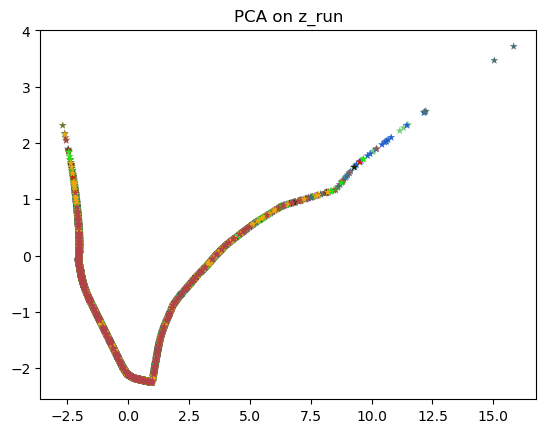

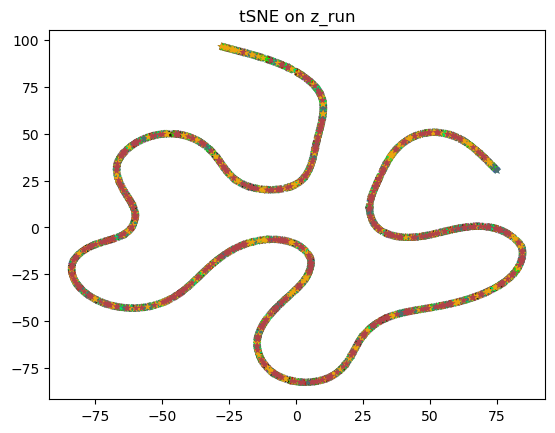

In [38]:
time_label_chunk = 500

label = 0
latent_copy = eeg_latents.copy()[:nirs_latents.shape[0]]
fake_labels = np.zeros((nirs_latents.shape[0]), dtype=int)
for i in range(0, latent_copy.shape[0], time_label_chunk):
    for j in range(time_label_chunk):
        fake_labels[i+j] = label
    label += 1
plot_clustering(latent_copy, fake_labels, engine='matplotlib', download = False)

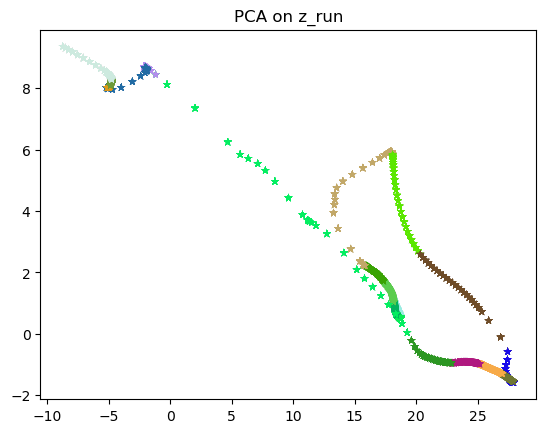

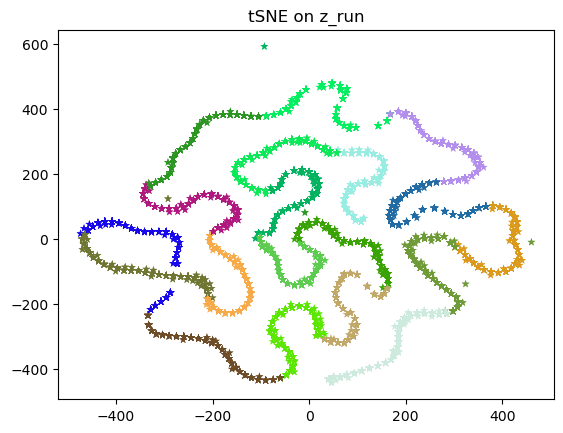

In [39]:
label = 0
latent_copy = nirs_latents.copy()
fake_labels = np.zeros((nirs_latents.shape[0]), dtype=int)
for i in range(0, latent_copy.shape[0], time_label_chunk):
    for j in range(time_label_chunk):
        fake_labels[i+j] = label
    label += 1
plot_clustering(latent_copy, fake_labels, engine='matplotlib', download = False)

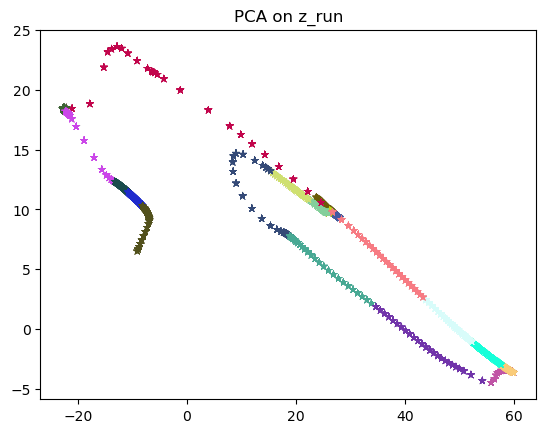

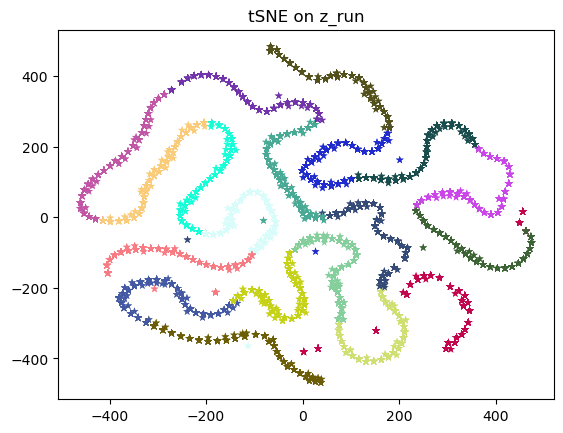

In [41]:
label = 0
nirs_latents_tensor = torch.from_numpy(nirs_latents).float()
latent_copy = mapping_model(nirs_latents_tensor).detach().numpy()
fake_labels = np.zeros((nirs_latents.shape[0]), dtype=int)
for i in range(0, latent_copy.shape[0], time_label_chunk):
    for j in range(time_label_chunk):
        fake_labels[i+j] = label
    label += 1
plot_clustering(latent_copy, fake_labels, engine='matplotlib', download = False)

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, sequence_length, number_of_features, hidden_dim, output_steps, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=number_of_features, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

def train_nirs_to_eeg_lstm(model, train_loader, num_epochs=10):
    model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = CorrelationLoss()
    loss_function = nn.MSELoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_data, eeg_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # Forward pass
            predictions = model(nirs_data)
            
            # Compute loss
            loss = loss_function(predictions, eeg_data)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_data.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_data.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return model

print(nirs_x_train.shape)
print(eeg_x_train.shape)
lstm_dataset = TensorDataset(nirs_x_train, eeg_x_train)
    
number_of_features = nirs_x_test.shape[2]
sequence_length = nirs_x_test.shape[1]
output_steps = eeg_x_train.shape[1]
hidden_dim = 128  # Number of LSTM units
batch_size = 500

model = LSTMModel(sequence_length=sequence_length, number_of_features=number_of_features, hidden_dim=hidden_dim, output_steps=output_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

dataloader = DataLoader(lstm_dataset, batch_size=batch_size, shuffle=True)

loss_function = nn.MSELoss()

lstm_model = train_nirs_to_eeg_lstm(model, dataloader, num_epochs=3)

torch.Size([89982, 150, 7])
torch.Size([89982, 1])
Train Epoch: 0 [0/89982 (0%)]	Loss: 0.001753
Train Epoch: 0 [5000/89982 (6%)]	Loss: 0.001595
Train Epoch: 0 [10000/89982 (11%)]	Loss: 0.001689
Train Epoch: 0 [15000/89982 (17%)]	Loss: 0.001630
Train Epoch: 0 [20000/89982 (22%)]	Loss: 0.001739
Train Epoch: 0 [25000/89982 (28%)]	Loss: 0.001702
Train Epoch: 0 [30000/89982 (33%)]	Loss: 0.001615
Train Epoch: 0 [35000/89982 (39%)]	Loss: 0.001639
Train Epoch: 0 [40000/89982 (44%)]	Loss: 0.001535
Train Epoch: 0 [45000/89982 (50%)]	Loss: 0.001661
Train Epoch: 0 [50000/89982 (56%)]	Loss: 0.001498
Train Epoch: 0 [55000/89982 (61%)]	Loss: 0.001650
Train Epoch: 0 [60000/89982 (67%)]	Loss: 0.001483
Train Epoch: 0 [65000/89982 (72%)]	Loss: 0.001858
Train Epoch: 0 [70000/89982 (78%)]	Loss: 0.001575
Train Epoch: 0 [75000/89982 (83%)]	Loss: 0.001515
Train Epoch: 0 [80000/89982 (89%)]	Loss: 0.001494
Train Epoch: 0 [85000/89982 (94%)]	Loss: 0.001394
Train Epoch: 1 [0/89982 (0%)]	Loss: 0.001569
Train Epoch

(9998, 1)
(9998, 1)
nirs r2: -0.08718065709314327


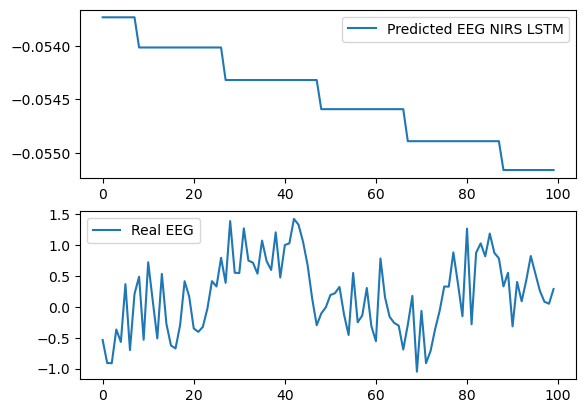

In [ ]:
def predict_eeg_from_nirs_lstm(model, nirs_data):
    model.eval()
    with torch.no_grad():
        predicted_eeg = model(nirs_data)
    return predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()

nirs_predicted_eeg_lstm = predict_eeg_from_nirs_lstm(lstm_model, nirs_x_test)

epoch_to_plot = 1
size = 100

print(eeg_test_data.shape)
print(nirs_predicted_eeg_lstm.shape)

from sklearn.metrics import r2_score
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(2)
axs[0].plot(nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS LSTM')
axs[0].legend()
axs[1].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[1].legend()
plt.show()

In [ ]:
sasd=asdasdasd

### Old stuff ###

In [ ]:

asdas=dasdasdas
class NIRS_Encoder(nn.Module):
    """
    Encoder network containing enrolled LSTM/GRU

    :param number_of_features: number of input features
    :param hidden_size: hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param dropout: percentage of nodes to dropout
    :param block: LSTM/GRU block
    """
    def __init__(self, number_of_features, hidden_size, hidden_layer_depth, latent_length, dropout, block = 'LSTM'):

        super(NIRS_Encoder, self).__init__()

        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length

        if block == 'LSTM':
            self.model = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        elif block == 'GRU':
            self.model = nn.GRU(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        else:
            raise NotImplementedError

    def forward(self, x):
        """Forward propagation of encoder. Given input, outputs the last hidden state of encoder

        :param x: input to the encoder, of shape (sequence_length, batch_size, number_of_features)
        :return: last hidden state of encoder, of shape (batch_size, hidden_size)
        """
        _, (h_end, c_end) = self.model(x)
        h_end = h_end[-1, :, :]
        return h_end


class NIRS_Lambda(nn.Module):
    """Lambda module converts output of encoder to latent vector

    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    """
    def __init__(self, hidden_size, latent_length):
        super(NIRS_Lambda, self).__init__()

        self.hidden_size = hidden_size
        self.latent_length = latent_length

        self.hidden_to_mean = nn.Linear(self.hidden_size, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)


        # self.bn_mean = nn.BatchNorm1d(latent_length)
        # self.bn_logvar = nn.BatchNorm1d(latent_length)

    def forward(self, cell_output):
        """Given last hidden state of encoder, passes through a linear layer, and finds the mean and variance

        :param cell_output: last hidden state of encoder
        :return: latent vector
        """

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        # self.latent_mean = self.bn_mean(self.latent_mean)
        # self.latent_logvar = self.bn_logvar(self.latent_logvar)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

class NIRS_VRAE(BaseEstimator, nn.Module):
    """Variational recurrent auto-encoder. This module is used for dimensionality reduction of timeseries

    :param sequence_length: length of the input sequence
    :param number_of_features: number of input features
    :param hidden_size:  hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param batch_size: number of timeseries in a single batch
    :param learning_rate: the learning rate of the module
    :param block: GRU/LSTM to be used as a basic building block
    :param n_epochs: Number of iterations/epochs
    :param dropout_rate: The probability of a node being dropped-out
    :param optimizer: ADAM/ SGD optimizer to reduce the loss function
    :param loss: SmoothL1Loss / MSELoss / ReconLoss / any custom loss which inherits from `_Loss` class
    :param boolean cuda: to be run on GPU or not
    :param print_every: The number of iterations after which loss should be printed
    :param boolean clip: Gradient clipping to overcome explosion
    :param max_grad_norm: The grad-norm to be clipped
    :param dload: Download directory where models are to be dumped
    """
    def __init__(self, sequence_length, number_of_features, hidden_size=90, hidden_layer_depth=2, latent_length=20,
                 batch_size=32, learning_rate=0.005, block='LSTM',
                 n_epochs=5, dropout_rate=0., optimizer='Adam', loss='MSELoss',
                 cuda=False, print_every=100, clip=True, max_grad_norm=5, dload='.'):

        super(NIRS_VRAE, self).__init__()


        self.dtype = torch.FloatTensor
        self.use_cuda = cuda

        if not torch.cuda.is_available() and self.use_cuda:
            self.use_cuda = False


        if self.use_cuda:
            self.dtype = torch.cuda.FloatTensor


        self.encoder = NIRS_Encoder(number_of_features = number_of_features,
                               hidden_size=hidden_size,
                               hidden_layer_depth=hidden_layer_depth,
                               latent_length=latent_length,
                               dropout=dropout_rate,
                               block=block)

        self.lmbd = NIRS_Lambda(hidden_size=hidden_size,
                           latent_length=latent_length)

        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.print_every = print_every
        self.clip = clip
        self.max_grad_norm = max_grad_norm
        self.is_fitted = False
        self.dload = dload

        if self.use_cuda:
            self.cuda()

        if optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        else:
            raise ValueError('Not a recognized optimizer')

        if loss == 'SmoothL1Loss':
            self.loss_fn = nn.SmoothL1Loss(size_average=False)
        elif loss == 'MSELoss':
            self.loss_fn = nn.MSELoss(size_average=False)

    def __repr__(self):
        return """VRAE(n_epochs={n_epochs},batch_size={batch_size},cuda={cuda})""".format(
                n_epochs=self.n_epochs,
                batch_size=self.batch_size,
                cuda=self.use_cuda)

    def forward(self, x):
        """
        Forward propagation which involves one pass from inputs to encoder to lambda to decoder

        :param x:input tensor
        :return: the decoded output, latent vector
        """
        cell_output = self.encoder(x)
        latent = self.lmbd(cell_output)

        return latent, self.lmbd.latent_mean, self.lmbd.latent_logvar

    def save(self, file_name):
        """
        Pickles the model parameters to be retrieved later

        :param file_name: the filename to be saved as,`dload` serves as the download directory
        :return: None
        """
        PATH = self.dload + '/' + file_name
        if os.path.exists(self.dload):
            pass
        else:
            os.mkdir(self.dload)
        torch.save(self.state_dict(), PATH)

    def load(self, PATH):
        """
        Loads the model's parameters from the path mentioned

        :param PATH: Should contain pickle file
        :return: None
        """
        self.is_fitted = True
        self.load_state_dict(torch.load(PATH))

# Aligning the fNIRS encoder
def train_nirs_encoder(eeg_encoder, nirs_vrae, train_loader, num_epochs=10):
    nirs_vrae.train()
    eeg_encoder.eval()  # Make sure the EEG encoder does not train
    optimizer = nirs_vrae.optimizer

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    loss_fn = CorrelationLoss()

    mapping_model = nn.Linear(50, 50)
    optimizer = optim.Adam(mapping_model.parameters(), lr=0.001)

    mapping_model.train()

    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (fnirs_data, eeg_data, meta_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # required to swap axes, since dataloader gives output in (batch_size x seq_len x num_of_features)
            fnirs_data = fnirs_data.permute(1,0,2)

            with torch.no_grad():
                eeg_latents, eeg_mu, eeg_log_var = eeg_encoder(eeg_data)
            nirs_latents, nirs_mu, nirs_log_var = nirs_vrae(fnirs_data)

            loss = loss_fn(nirs_latents, eeg_latents) + F.mse_loss(nirs_mu, eeg_mu) + F.mse_loss(nirs_log_var, eeg_log_var)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * fnirs_data.shape[1]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / fnirs_data.shape[1]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return nirs_vrae

sequence_length = nirs_x_train.shape[1]  # Number of samples in each EEG window
number_of_features = nirs_x_train.shape[2]  # Number of channels at each time point

hidden_size = 128
hidden_layer_depth = 1
batch_size = 500
learning_rate = 0.005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: Adam, SGD
cuda = True # options: True, False
print_every=30
clip = False # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

# Create the model, optimizer, and loss function
nirs_vrae = NIRS_VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_dim,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')


nirs_train_loader = DataLoader(nirs_train_dataset, batch_size=batch_size, shuffle=True)

nirs_vrae = train_nirs_encoder(eeg_encoder, nirs_vrae, nirs_train_loader, num_epochs=n_epochs)


NameError: name 'dasdasdas' is not defined

In [ ]:
crop_index = 1000

# plot entire prediction and r squared
# Flatten the data
print(nirs_predicted_eeg.shape)
print(eeg_predicted_eeg.shape)
print(eeg_test_data.shape)

full_signal_nirs_prediction = nirs_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg_prediction = eeg_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg = eeg_test_data.reshape(-1)[:crop_index]

print(full_signal_nirs_prediction.shape)
print(full_signal_eeg_prediction.shape)
print(full_signal_eeg.shape)

# Calculate R squared
from sklearn.metrics import r2_score
r2 = r2_score(full_signal_eeg, full_signal_nirs_prediction)
print(r2)

# plot

fig, axs = plt.subplots(3)
axs[0].plot(full_signal_nirs_prediction, label='Predicted EEG NIRS')
axs[0].legend()
axs[1].plot(full_signal_eeg_prediction, label='Predicted EEG EEG')
axs[1].legend()
axs[2].plot(full_signal_eeg, label='Real EEG')
axs[2].legend()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming `model` is your trained VAE and `data_loader` is your DataLoader for the dataset
def extract_latent_space(model, data_loader, index_for_label=0):
    model.eval()
    with torch.no_grad():
        latents = []
        labels = []  # Assuming you have some labels of interest, e.g., participant IDs
        for data, targets, meta_data in data_loader:
            mu, log_var = model.encoder(data)
            z = model.reparameterize(mu, log_var)
            latents.append(z)
            labels.append(meta_data[:, index_for_label])  # Change indexing based on what label you're interested in
        latents = torch.cat(latents).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
    return latents, labels

def plot_latent_space(model, data_Loader, latent_name='participant'):
    if latent_name == 'participant':
        index_for_label = 0
        label_type = 'discrete'
    elif latent_name == 'temporal':
        index_for_label = 1
        label_type = 'continuous'

    latents, labels = extract_latent_space(model, data_Loader, index_for_label)

    # Applying t-SNE for dimensionality reduction to 3 components
    tsne = TSNE(n_components=3, random_state=42)
    latents_reduced = tsne.fit_transform(latents)

    # Plotting in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if label_type == 'discrete':
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        legend = ax.legend(*scatter.legend_elements(), title="Participant ID")
        ax.add_artist(legend)
    elif label_type == 'continuous':
        # colorbar
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Temporal ID')

    ax.set_title(f't-SNE visualization of the {latent_name} Latent Space')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    plt.show()

# Plot the latent space
plot_latent_space(eeg_model, train_loader, latent_name='temporal')

ValueError: too many values to unpack (expected 2)

In [ ]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
adsadsa=asdasd
# Stack participant and distance information along the second dimension
train_dataset = TensorDataset(torch.from_numpy(eeg_data_train))
print(eeg_data_train.shape)

# Assuming each EEG window is flattened into a vector
number_of_features = eeg_data_train.shape[2] # number of features in each time point
sequence_length = eeg_data_train.shape[1] #200  # Number of samples in each EEG window

hidden_size = 128
hidden_layer_depth = 3
latent_length = 50
batch_size = 32
learning_rate = 0.0005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU


# from timeseries_clustering_vae.vrae.utils import *
# X_train, X_val, y_train, y_val = open_data('timeseries_clustering_vae/data', ratio_train=0.9)
# train_dataset = TensorDataset(torch.from_numpy(X_train))
# print(X_train.shape)
# number_of_features = X_train.shape[2]
# sequence_length = X_train.shape[1]
# adasd=asdasd

# Create the model, optimizer, and loss function
eeg_model = VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_length,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')

eeg_model.fit(train_dataset)

eeg_encoder = eeg_model.encoder
eeg_decoder = eeg_model.decoder
